In [1]:
from skimage.segmentation import watershed, felzenszwalb
from skimage.filters import sobel
import pandas as pd
from pathlib import Path
import cv2
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.filters import rank
from scipy import ndimage as ndi
from skimage.morphology import disk
import sklearn.metrics

In [2]:
# Here is a function to load the data
def load_dataset(dataset_dir):
    dataset_list = []
    # Note: It's very important to load the images in the correct numerical order!
    for image_file in list(sorted(Path(dataset_dir).glob("*.png"), key=lambda filename: int(filename.name.rstrip(".png")))):
        dataset_list.append(cv2.imread(str(image_file), cv2.IMREAD_GRAYSCALE))
    return np.stack(dataset_list, axis=0)

# Load the train and test sets
# If you've put the shortcut directly in your drive, this should work out of the box
# Else, edit the path
data_dir = Path("./")
data_train = load_dataset(data_dir / "train-images")
data_test = load_dataset(data_dir / "test-images")

# Handling the data

In [3]:
# Load the train labels
# Note the transpose!
labels_train = pd.read_csv("y_train.csv", index_col=0).T

In [4]:
#Change it with what you need

data_train_1 = data_train[:700]
unlabeled_train_data = data_train[800:]

label_train_1 = labels_train[:700]
unlabeled_train_labels = labels_train[800:]

data_train_2 = data_train[350:700]
label_train_2 = labels_train.iloc[350:700]

data_val = data_train[700:800]
label_val = labels_train.iloc[700:800]

In [5]:
# The train data is a numpy array of 1000 images of 512*512
print(f"X_train shape: {data_train.shape}")
# The train label is a dataframe of 1000 rows with 262144 (=512x512) columns
print(f"Y_train shape: {labels_train.shape}")

X_train shape: (2000, 256, 256)
Y_train shape: (2000, 65536)


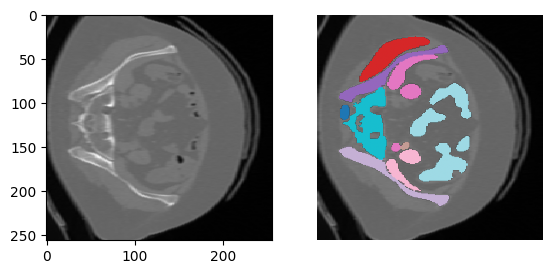

In [6]:
# Let's display some data
# Here is a function to display side by side a slide and a segmented mask
def plot_slice_seg(slice_image, seg):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(slice_image, cmap="gray")
    axes[1].imshow(slice_image, cmap="gray")
    seg_masked = np.ma.masked_where(seg.reshape((256,256)) == 0, (seg.reshape((256,256))))
    axes[1].imshow(seg_masked, cmap="tab20")
    plt.axis("off")

# Let's try it on a slide and ites segmentation mask
# Note: we have to reshape the rows of the dataframe into a 256*256 matrix
plot_slice_seg(data_train[0], labels_train.iloc[0].values.reshape((256,256)))

# Let's compute a baseline

In [7]:
# Let's take a very basic watershed baseline
def compute_baseline_one_sample(data_slice):
    edges = sobel(data_slice)
    denoised = rank.median(data_slice, disk(2))
    markers = rank.gradient(denoised, disk(5)) < 20
    markers = ndi.label(markers)[0]
    label_predicted = watershed(edges, markers=markers, compactness=0.0001)
    return label_predicted

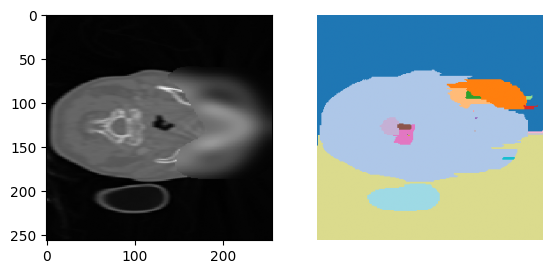

In [8]:
# Let's display the results
# Not too bad!
plot_slice_seg(data_train[2], compute_baseline_one_sample(data_train[2]))

## Let's measure its performances

In [9]:
# Compute the baseline on a whole dataset
def compute_baseline(dataset: np.array):
    labels_predicted_list = []
    for data_index in tqdm(range(len(dataset))):
        data_slice = dataset[data_index]
        label_predicted = compute_baseline_one_sample(data_slice)
        labels_predicted_list.append(label_predicted)
    return pd.DataFrame(np.stack(labels_predicted_list, axis=0).reshape((len(labels_predicted_list), -1)))

In [10]:
# Compute baseline on a few train data
labels_val_predicted_baseline = compute_baseline(data_val)

NameError: name 'data_val' is not defined

In [11]:
NUM_CLASSES = 54 # 55 classes in total, but the first one is the background


def dice_image(prediction, ground_truth):
    intersection = np.sum(prediction * ground_truth)
    if np.sum(prediction) == 0 and np.sum(ground_truth) == 0:
        return np.nan
    return 2 * intersection / (np.sum(prediction) + np.sum(ground_truth))


def dice_multiclass(prediction, ground_truth):
    dices = []
    for i in range(1, NUM_CLASSES + 1): # skip background
        dices.append(dice_image(prediction == i, ground_truth == i))
    return np.array(dices)

def dice_pandas(y_true_df: pd.DataFrame, y_pred_df: pd.DataFrame) -> float:
    """Compute the dice score for each sample in the dataset and then average it"""
    y_pred_df = y_pred_df.T
    y_true_df = y_true_df.T
    individual_dice = []
    for row_index in range(y_true_df.values.shape[0]):
        dices = dice_multiclass(y_true_df.values[row_index].ravel(), y_pred_df.values[row_index].ravel())
        individual_dice.append(dices)

    final = np.stack(individual_dice)
    # First, average over images for each class
    # Then, average over classes
    cls_dices = np.nanmean(final, axis=0)
    return float(np.nanmean(cls_dices))


In [10]:
import torch

NUM_CLASSES = 54 # 55 classes in total, but the first one is the background

def dice_image(prediction: torch.Tensor, ground_truth: torch.Tensor) -> float:
    intersection = torch.sum(prediction * ground_truth).item()
    if torch.sum(prediction).item() == 0 and torch.sum(ground_truth).item() == 0:
        return float('nan')
    return 2 * intersection / (torch.sum(prediction).item() + torch.sum(ground_truth).item())

def dice_multiclass(prediction: torch.Tensor, ground_truth: torch.Tensor, num_classes: int) -> torch.Tensor:
    dices = []
    for i in range(1, num_classes + 1):  # skip background
        dices.append(dice_image((prediction == i).float(), (ground_truth == i).float()))
    return torch.tensor(dices, dtype=torch.float32)

def dice_torch(y_true: torch.Tensor, y_pred: torch.Tensor, num_classes: int) -> float:
    """Compute the dice score for each sample in the dataset and then average it"""
    individual_dice = []
    for i in range(y_true.shape[0]):  # itérer sur le batch
        dices = dice_multiclass(y_pred[i].flatten(), y_true[i].flatten(), num_classes)
        individual_dice.append(dices)
    
    final = torch.stack(individual_dice)
    # First, average over images for each class
    # Then, average over classes
    cls_dices = torch.nanmean(final, dim=0)
    return float(torch.nanmean(cls_dices))

In [14]:
# Compute the metric on the validation set
dice_pandas(labels_val, labels_val_predicted_baseline)
# We get => (0.0011196021617737601); Not so bad, but room for improvements!
# Let's see if you can do better!

0.001158922567158145

## GET FEATURES

In [11]:
from transformers import AutoModel
from PIL import Image
import requests
import torch
import torchvision.transforms as T
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Custom dataset class for multiple grayscale CT scans, this is what we put our data in
class CTDataset(Dataset):
    def __init__(self, images):
        """
        images: A list or NumPy array of shape (N, 256, 256) containing grayscale CT scans.
        """
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]  # Get (256, 256) image
        #return img
        return preprocess_image(img)  # Convert to 3-channel 224x224 tensor
# # Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Define preprocessing transforms
transform = T.Compose([
    T.Resize(224),  # Resize to DINOv2 expected input size
    T.ToTensor(),  # Convert to tensor
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25])  # Normalize
])
# transform = T.Compose([
#     T.Resize(224),
#     T.CenterCrop(224),
#     T.ToTensor(),
#     T.Normalize(mean=[0.5], std=[0.5]),
# ])

def preprocess_image(image_array):
    """
    Convert grayscale (256x256) CT scan to a format usable by DINOv2.
    - image_array: NumPy array of shape (256, 256), values in range [0,1].
    - Returns: Tensor of shape (3, 224, 224) ready for DINOv2.
    """
    img = np.stack([image_array] * 3, axis=-1)  # Convert grayscale (H,W) → RGB (H,W,3)
    img = Image.fromarray((img * 255).astype(np.uint8))  # Convert to PIL image
    img = transform(img)  # Apply resizing and normalization
    return img

In [13]:
#THE CELL WHERE YOU CAN CHANGE STUFF

#LOAD MODEL HERE
#in order from smallest to largest, dinov2_vits14 is the smallest model
# model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
# model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
# model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
# model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14').to(device)
# LOAD DATASET HERE

#if test data, define the test data, and then put it inside CTDataset
Dataset_train_1 = CTDataset(data_train_1)
DataLoader_train_1 = DataLoader(Dataset_train_1, batch_size=8, shuffle=False)

Dataset_train_2 = CTDataset(data_train_2)
DataLoader_train_2 = DataLoader(Dataset_train_2, batch_size=8, shuffle=False)

Dataset_test = CTDataset(data_test)
DataLoader_test = DataLoader(Dataset_test, batch_size=8, shuffle=False)

Dataset_val = CTDataset(data_val)
DataLoader_val = DataLoader(Dataset_val, batch_size=8, shuffle=False)

# Extract features for all images
# train_patch_features_list = []
# train_cls_features_list = []
# with torch.no_grad():
#     for batch in tqdm(train_dataloader):
#         batch = batch.to(device)
#         features_dict = model.forward_features(batch)
#         #print(features_dict)
#         patch_features = features_dict["x_norm_patchtokens"]  # Patch features
#         cls_features = features_dict["x_norm_clstoken"]  # Patch features
#         train_patch_features_list.append(patch_features)
#         train_cls_features_list.append(cls_features)
#         #train_features_list.append(features.cpu().numpy())

# valid_patch_features_list = []
# valid_cls_features_list = []
# with torch.no_grad():
#     for batch in tqdm(valid_dataloader):
#         batch = batch.to(device)
#         features_dict = model.forward_features(batch)
#         patch_features = features_dict["x_norm_patchtokens"]  # Patch features
#         cls_features = features_dict["x_norm_clstoken"]  # Patch features
#         valid_patch_features_list.append(patch_features)
#         valid_cls_features_list.append(cls_features)

#GET FEATURES
data_train_1_features = []
with torch.no_grad():
    for batch in tqdm(DataLoader_train_1):
        batch = batch.to(device)
        features_dict = model.forward_features(batch)
        patch_features = features_dict["x_norm_patchtokens"]  # Patch features
        data_train_1_features.append(patch_features)

data_train_2_features = []
with torch.no_grad():
    for batch in tqdm(DataLoader_train_2):
        batch = batch.to(device)
        features_dict = model.forward_features(batch)
        patch_features = features_dict["x_norm_patchtokens"]  # Patch features
        data_train_2_features.append(patch_features)

data_val_features = []
with torch.no_grad():
    for batch in tqdm(DataLoader_val):
        batch = batch.to(device)
        features_dict = model.forward_features(batch)
        patch_features = features_dict["x_norm_patchtokens"]  # Patch features
        data_val_features.append(patch_features)

data_test_features = []
with torch.no_grad():
    for batch in tqdm(DataLoader_test):
        batch = batch.to(device)
        features_dict = model.forward_features(batch)
        patch_features = features_dict["x_norm_patchtokens"]  # Patch features
        data_test_features.append(patch_features)




#**ALL FEATURES HERE**
#features = torch.cat(all_patch_features_list, dim=0)

Using cache found in C:\Users\yanni/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\yanni/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\yanni/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\yanni/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
100%|██████████| 63/63 [00:16<00:00,  3.92it/s]


torch.Size([8, 256, 768])


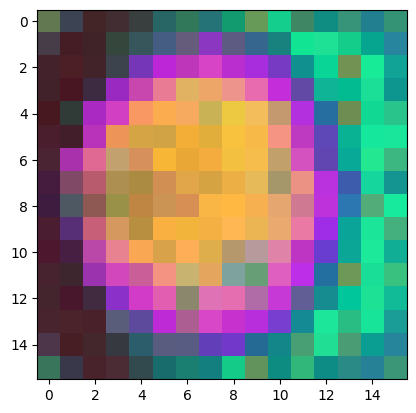

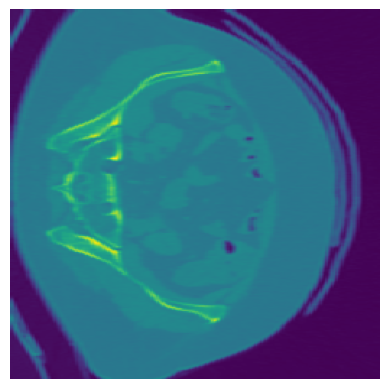

In [14]:
##EVerything below is related to Kmeans, trying to see the effectiveness of the features

import torchvision.transforms as transforms
import torchvision.transforms.functional as F

#PCA visualization, to see if features are good
print(data_train_2_features[0].shape)
b_patch_features = data_train_2_features[0][1]
pca = PCA(n_components=3)
pca_features = pca.fit_transform(b_patch_features.squeeze(0).cpu().numpy())

# Normalize PCA features for visualization
pca_features = (pca_features - pca_features.min()) / (pca_features.max() - pca_features.min())
pca_features = (pca_features * 255).astype(np.uint8)

# Visualize the extracted features as an image
plt.imshow(pca_features.reshape(16, 16, 3))
plt.show()
plt.axis("off")
plt.savefig('meta_dog_features.png')
plt.imshow(data_train[0])

## PUT EVERYTHING IN DATALOADER

In [15]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [16]:
print(f"X_train shape: {data_train.shape}")
print(f"Y_train shape: {labels_train.shape}")

X_train shape: (2000, 256, 256)
Y_train shape: (2000, 65536)


In [17]:
data_train_1_tensor_features = torch.cat(data_train_1_features, dim=0).cpu()
data_train_2_tensor_features = torch.cat(data_train_2_features, dim=0).cpu()
data_test_tensor_features = torch.cat(data_test_features, dim=0).cpu()
data_val_tensor_features = torch.cat(data_val_features, dim=0).cpu()

torch.cuda.empty_cache() #Clean cuda memory (the model take a lot of place)

# Vérifier les dimensions
print("Train 1 features shape:", data_train_1_tensor_features.shape)
print("Train 2 features shape:", data_train_2_tensor_features.shape)
print("Test features shape:", data_test_tensor_features.shape)
print("Validation features shape:", data_val_tensor_features.shape)

Train 1 features shape: torch.Size([700, 256, 768])
Train 2 features shape: torch.Size([350, 256, 768])
Test features shape: torch.Size([500, 256, 768])
Validation features shape: torch.Size([100, 256, 768])


In [18]:
#patch_features = torch.load("all_patch_features.pth")

#features = torch.cat(patch_features, dim=0)

#print("Features shape:", features.shape)    

In [19]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np


import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd

class MedicalSegDataset(Dataset):
    def __init__(self, images, labels=None, patch_features_tensor=None, is_test=False):
        # Convertir en numpy si c'est un DataFrame Pandas
        if isinstance(images, pd.DataFrame):
            images = images.to_numpy()
        if isinstance(labels, pd.DataFrame) and labels is not None:
            labels = labels.to_numpy()

        self.images = images
        self.labels = labels
        self.patch_features_tensor = patch_features_tensor  # Tenseur de taille (2000, 256, 384)
        self.is_test = is_test  # Indicateur pour savoir si on est en phase de test

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Charger l'image
        image = torch.tensor(self.images[idx], dtype=torch.float32).unsqueeze(0)  # (1, 256, 256)

        # Charger les patch_features
        patch_feature = self.patch_features_tensor[idx]  # (256, 384)
        patch_feature = patch_feature.reshape(16, 16, 768).permute(2, 0, 1)  # (384, 16, 16)

        if self.is_test:
            # En phase de test, on ne retourne pas les labels
            return image, patch_feature
        else:
            # En phase d'entraînement, on retourne les labels
            label = torch.tensor(self.labels[idx], dtype=torch.long).view(256, 256)  # (256, 256)
            return image, label, patch_feature


test_dataset = MedicalSegDataset(data_test, patch_features_tensor=data_test_tensor_features, is_test=True)  

test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

# Inspection du test_loader
for batch_idx, batch_data in enumerate(test_loader):
    image, feature = batch_data  

    print(f"Batch {batch_idx + 1}:")
    print(f"  Image shape: {image.shape}, dtype: {image.dtype}, device: {image.device}")
    print(f"  Feature shape: {feature.shape}, dtype: {feature.dtype}, device: {feature.device}")

    if batch_idx >= 2:
        break

val_dataset = MedicalSegDataset(data_val, label_val, data_val_tensor_features)  # Utiliser 100 images pour la validation

val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


# 📌 Création des datasets
train_dataset_1 = MedicalSegDataset(data_train_1, label_train_1, data_train_1_tensor_features)  # Utiliser 350 images pour l'entraînement
train_dataset_2 = MedicalSegDataset(data_train_2,label_train_2, data_train_2_tensor_features)  # Utiliser 350 images pour le 2eme entrainement

train_loader_1 = DataLoader(train_dataset_1, batch_size=4, shuffle=True)
train_loader_2 = DataLoader(train_dataset_2, batch_size=4, shuffle=False)



# Inspect train_loader
for batch_idx, batch_data in enumerate(train_loader_1):
    image, label, feature = batch_data  

    print(f"Batch {batch_idx + 1}:")
    print(f"  Image shape: {image.shape}, dtype: {image.dtype}, device: {image.device}")
    print(f"  Label shape: {label.shape}, dtype: {label.dtype}, device: {label.device}")
    print(f"  Feature shape: {feature.shape}, dtype: {feature.dtype}, device: {feature.device}")

    if batch_idx >= 2:
        break

# Inspect val_loader
for batch_idx, batch_data in enumerate(train_loader_2):
    image, label, feature = batch_data  

    print(f"Batch {batch_idx + 1}:")
    print(f"  Image shape: {image.shape}, dtype: {image.dtype}, device: {image.device}")
    print(f"  Label shape: {label.shape}, dtype: {label.dtype}, device: {label.device}")
    print(f"  Feature shape: {feature.shape}, dtype: {feature.dtype}, device: {feature.device}")

    if batch_idx >= 2:
        break

Batch 1:
  Image shape: torch.Size([4, 1, 256, 256]), dtype: torch.float32, device: cpu
  Feature shape: torch.Size([4, 768, 16, 16]), dtype: torch.float32, device: cpu
Batch 2:
  Image shape: torch.Size([4, 1, 256, 256]), dtype: torch.float32, device: cpu
  Feature shape: torch.Size([4, 768, 16, 16]), dtype: torch.float32, device: cpu
Batch 3:
  Image shape: torch.Size([4, 1, 256, 256]), dtype: torch.float32, device: cpu
  Feature shape: torch.Size([4, 768, 16, 16]), dtype: torch.float32, device: cpu
Batch 1:
  Image shape: torch.Size([4, 1, 256, 256]), dtype: torch.float32, device: cpu
  Label shape: torch.Size([4, 256, 256]), dtype: torch.int64, device: cpu
  Feature shape: torch.Size([4, 768, 16, 16]), dtype: torch.float32, device: cpu
Batch 2:
  Image shape: torch.Size([4, 1, 256, 256]), dtype: torch.float32, device: cpu
  Label shape: torch.Size([4, 256, 256]), dtype: torch.int64, device: cpu
  Feature shape: torch.Size([4, 768, 16, 16]), dtype: torch.float32, device: cpu
Batch 3

In [22]:
class DiceLoss(nn.Module):
    def __init__(self, n_classes):
        super(DiceLoss, self).__init__()
        self.n_classes = n_classes

    def _one_hot_encoder(self, input_tensor):
        tensor_list = []
        for i in range(self.n_classes):
            temp_prob = input_tensor == i  # * torch.ones_like(input_tensor)
            tensor_list.append(temp_prob.unsqueeze(1))
        output_tensor = torch.cat(tensor_list, dim=1)
        return output_tensor.float()

    def _dice_loss(self, score, target):
        target = target.float()
        smooth = 1e-5
        intersect = torch.sum(score * target)
        y_sum = torch.sum(target * target)
        z_sum = torch.sum(score * score)
        loss = (2 * intersect + smooth) / (z_sum + y_sum + smooth)
        loss = 1 - loss
        return loss

    def forward(self, inputs, target, weight=None, softmax=False):
        if softmax:
            inputs = torch.softmax(inputs, dim=1)
        target = self._one_hot_encoder(target)
        if weight is None:
            weight = [1] * self.n_classes
        assert inputs.size() == target.size(), 'predict {} & target {} shape do not match'.format(inputs.size(), target.size())
        class_wise_dice = []
        loss = 0.0
        for i in range(0, self.n_classes):
            dice = self._dice_loss(inputs[:, i], target[:, i])
            class_wise_dice.append(1.0 - dice.item())
            loss += dice * weight[i]
        return loss / self.n_classes


## MODEL WITH ONLY IMAGES

In [20]:
from monai.networks.nets import SwinUNETR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Change img_size to match the actual image size (256, 256)
model_swin_both = SwinUNETR(
    img_size=(256, 256),  # Match the actual input image size
    in_channels=1,  # Images CT-scan en niveaux de gris
    out_channels=NUM_CLASSES+1,  # Nombre de classes
    use_checkpoint=True,  # Gradient checkpointing pour économiser la mémoire
    spatial_dims=2,  # Important pour utiliser la version 2D
).to(device)

torch.backends.cudnn.benchmark = True
ce_loss = nn.CrossEntropyLoss()
#dice_loss = DiceLoss(NUM_CLASSES+1)
optimizer = optim.AdamW(model_swin_both.parameters(), lr=0.0005, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

# Boucle d'entraînement simple
num_epochs = 100  # Ajuste selon tes besoins
losses = []
val_losses = []
counter = 0  # Compteur d'époques sans amélioration
patience = 10  # Nombre d'époques sans amélioration avant d'arrêter
best_val_loss = float('inf')

for epoch in tqdm(range(num_epochs)):
    model_swin_both.train()
    running_loss = 0.0

    for images, labels, features in train_loader_1:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_swin_both(images)
        preds = torch.argmax(outputs, dim=1)
        
        loss_ce = ce_loss(outputs, labels)
        loss_dice = 1-dice_torch(preds, labels, NUM_CLASSES+1)
        loss = 0.4 * loss_ce + 0.6 * loss_dice
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    losses.append(running_loss / len(train_loader_1))
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader_1):.4f}")

    # ---- ÉVALUATION ----
    model_swin_both.eval()  # Met le modèle en mode évaluation

    val_loss = 0.0  # Variable pour accumuler la perte de validation
    with torch.no_grad():
        for images, labels, features in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Passer les images dans le modèle
            outputs = model_swin_both(images)
            preds = torch.argmax(outputs, dim=1)
            
            loss_dice = 1-dice_torch(preds, labels, NUM_CLASSES+1)
            val_loss +=  loss_dice

    # Moyenne de la perte de validation
    val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {val_loss:.4f}")

    # Optionnel : afficher la progression de la perte de validation
    val_losses.append(val_loss)

    # Sauvegarder le modèle si la perte de validation est la meilleure vue jusqu'à présent
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_swin_both.state_dict(), "best_model_vanilla.pth")
        counter = 0
    else:
        counter += 1
    if counter == patience:
        print(f"Arrêt prématuré à l'époque {epoch+1}")
        break



c:\Users\yanni\anaconda3\lib\site-packages\monai\utils\deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)
C:\Users\yanni\AppData\Local\Temp\ipykernel_19208\1615832080.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Loss: 1.6808


  1%|          | 1/100 [01:04<1:46:02, 64.27s/it]

Validation Loss: 0.9974
Epoch [2/100], Loss: 1.1093


  2%|▏         | 2/100 [01:59<1:36:27, 59.06s/it]

Validation Loss: 1.0000
Epoch [3/100], Loss: 0.8939


  3%|▎         | 3/100 [02:55<1:32:46, 57.39s/it]

Validation Loss: 1.0000
Epoch [4/100], Loss: 0.8439


  4%|▍         | 4/100 [03:50<1:30:35, 56.62s/it]

Validation Loss: 0.9998
Epoch [5/100], Loss: 0.8260


  5%|▌         | 5/100 [04:46<1:29:02, 56.23s/it]

Validation Loss: 0.9993
Epoch [6/100], Loss: 0.8105


  6%|▌         | 6/100 [05:41<1:27:50, 56.07s/it]

Validation Loss: 0.9939
Epoch [7/100], Loss: 0.7950


  7%|▋         | 7/100 [06:37<1:26:33, 55.84s/it]

Validation Loss: 0.9878
Epoch [8/100], Loss: 0.7846
Validation Loss: 0.9784


  8%|▊         | 8/100 [07:33<1:25:37, 55.85s/it]

Epoch [9/100], Loss: 0.7812


  9%|▉         | 9/100 [08:28<1:24:32, 55.75s/it]

Validation Loss: 0.9834
Epoch [10/100], Loss: 0.7698


 10%|█         | 10/100 [09:24<1:23:32, 55.70s/it]

Validation Loss: 0.9823
Epoch [11/100], Loss: 0.7642


 11%|█         | 11/100 [10:19<1:22:31, 55.64s/it]

Validation Loss: 0.9774
Epoch [12/100], Loss: 0.7586


 12%|█▏        | 12/100 [11:15<1:21:29, 55.57s/it]

Validation Loss: 0.9829
Epoch [13/100], Loss: 0.7539


 13%|█▎        | 13/100 [12:10<1:20:25, 55.47s/it]

Validation Loss: 0.9835
Epoch [14/100], Loss: 0.7488


 14%|█▍        | 14/100 [13:05<1:19:33, 55.50s/it]

Validation Loss: 0.9788
Epoch [15/100], Loss: 0.7459


 15%|█▌        | 15/100 [14:01<1:18:49, 55.65s/it]

Validation Loss: 0.9766
Epoch [16/100], Loss: 0.7405


 16%|█▌        | 16/100 [14:57<1:18:05, 55.79s/it]

Validation Loss: 0.9827
Epoch [17/100], Loss: 0.7364


 17%|█▋        | 17/100 [15:53<1:17:12, 55.82s/it]

Validation Loss: 0.9699
Epoch [18/100], Loss: 0.7316


 18%|█▊        | 18/100 [16:49<1:16:15, 55.80s/it]

Validation Loss: 0.9790
Epoch [19/100], Loss: 0.7285


 19%|█▉        | 19/100 [17:45<1:15:15, 55.75s/it]

Validation Loss: 0.9668
Epoch [20/100], Loss: 0.7244


 20%|██        | 20/100 [18:40<1:14:19, 55.74s/it]

Validation Loss: 0.9662
Epoch [21/100], Loss: 0.7211


 21%|██        | 21/100 [19:36<1:13:20, 55.70s/it]

Validation Loss: 0.9644
Epoch [22/100], Loss: 0.7185


 22%|██▏       | 22/100 [20:32<1:12:28, 55.75s/it]

Validation Loss: 0.9675
Epoch [23/100], Loss: 0.7166


 23%|██▎       | 23/100 [21:28<1:11:36, 55.80s/it]

Validation Loss: 0.9630
Epoch [24/100], Loss: 0.7132


 24%|██▍       | 24/100 [22:24<1:10:45, 55.86s/it]

Validation Loss: 0.9555
Epoch [25/100], Loss: 0.7090


 25%|██▌       | 25/100 [23:20<1:09:50, 55.87s/it]

Validation Loss: 0.9528
Epoch [26/100], Loss: 0.7039


 26%|██▌       | 26/100 [24:16<1:08:51, 55.83s/it]

Validation Loss: 0.9621
Epoch [27/100], Loss: 0.7084


 27%|██▋       | 27/100 [25:11<1:07:53, 55.80s/it]

Validation Loss: 0.9698
Epoch [28/100], Loss: 0.6981


 28%|██▊       | 28/100 [26:07<1:07:05, 55.91s/it]

Validation Loss: 0.9593
Epoch [29/100], Loss: 0.6988


 29%|██▉       | 29/100 [27:04<1:06:14, 55.98s/it]

Validation Loss: 0.9409
Epoch [30/100], Loss: 0.6977


 30%|███       | 30/100 [27:59<1:05:13, 55.91s/it]

Validation Loss: 0.9468
Epoch [31/100], Loss: 0.6904


 31%|███       | 31/100 [28:55<1:04:18, 55.92s/it]

Validation Loss: 0.9483
Epoch [32/100], Loss: 0.6886


 32%|███▏      | 32/100 [29:51<1:03:19, 55.88s/it]

Validation Loss: 0.9247
Epoch [33/100], Loss: 0.6867


 33%|███▎      | 33/100 [30:47<1:02:19, 55.81s/it]

Validation Loss: 0.9300
Epoch [34/100], Loss: 0.6843


 34%|███▍      | 34/100 [31:43<1:01:33, 55.96s/it]

Validation Loss: 0.9289
Epoch [35/100], Loss: 0.6785


 35%|███▌      | 35/100 [32:39<1:00:32, 55.89s/it]

Validation Loss: 0.9326
Epoch [36/100], Loss: 0.6796


 36%|███▌      | 36/100 [33:34<59:33, 55.84s/it]  

Validation Loss: 0.9418
Epoch [37/100], Loss: 0.6801


 37%|███▋      | 37/100 [34:30<58:38, 55.86s/it]

Validation Loss: 0.9352
Epoch [38/100], Loss: 0.6709


 38%|███▊      | 38/100 [35:26<57:40, 55.82s/it]

Validation Loss: 0.9507
Epoch [39/100], Loss: 0.6738


 39%|███▉      | 39/100 [36:22<56:43, 55.79s/it]

Validation Loss: 0.9278
Epoch [40/100], Loss: 0.6717


 40%|████      | 40/100 [37:18<55:51, 55.86s/it]

Validation Loss: 0.9268
Epoch [41/100], Loss: 0.6684


 41%|████      | 41/100 [38:14<54:56, 55.88s/it]

Validation Loss: 0.9354
Epoch [42/100], Loss: 0.6659


 41%|████      | 41/100 [39:10<56:22, 57.34s/it]

Validation Loss: 0.9392
Arrêt prématuré à l'époque 42


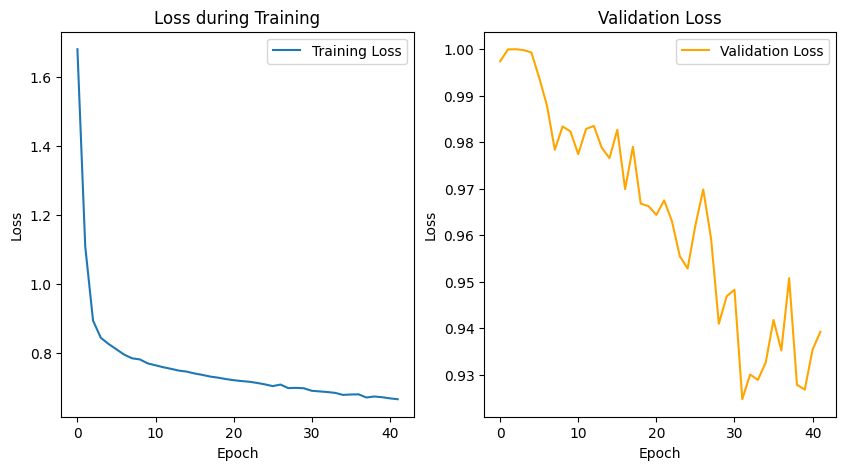

In [23]:
# ---- GRAPHIQUES ----
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss during Training")
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_losses, label="Validation Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.legend()

plt.show()

In [24]:
model_swin_both.eval()  # Met le modèle en mode évaluation

eval = 0.0
with torch.no_grad():
    for images, labels, features in (val_loader):
        images, labels, features = images.to(device), labels.to(device), features.to(device)

        # Passer les images dans le modèle
        outputs = model_swin_both(images)

        # Obtenir les prédictions en prenant l'argmax sur la dimension des classes
        preds = torch.argmax(outputs, dim=1)

        dice_score = dice_torch(preds, labels, NUM_CLASSES+1)
        eval += dice_score
    dice_score_both = eval / len(val_loader)

print(f"Validation Dice Score: {dice_score_both:.4f}")

Validation Dice Score: 0.0608


In [21]:
torch.save(model_swin_both.state_dict(), 'best_model_vanilla.pth')
torch.cuda.empty_cache()

In [55]:
from monai.networks.nets import SwinUNETR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recréer le modèle avec la même architecture
best_model = SwinUNETR(
    img_size=(256, 256),  
    in_channels=1,  
    out_channels=NUM_CLASSES+1,  
    use_checkpoint=True,  
    spatial_dims=2,  
).to(device)

# Charger les poids
best_model.load_state_dict(torch.load("best_model_vanilla.pth"))
best_model.eval()


c:\Users\yanni\anaconda3\lib\site-packages\monai\utils\deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)
C:\Users\yanni\AppData\Local\Temp\ipykernel_14976\826496867.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be

SwinUNETR(
  (swinViT): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(1, 24, kernel_size=(2, 2), stride=(2, 2))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers1): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0-1): 2 x SwinTransformerBlock(
            (norm1): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=24, out_features=72, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=24, out_features=24, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
            (mlp): MLPBlock(
              (linear1): Linear(in_features=24, out_features=96, bias=True)
              (linear2): Linear(in_features=96, ou

In [ ]:
best_model.eval()  # Met le modèle en mode évaluation

eval = 0.0
with torch.no_grad():
    for images, labels, features in (val_loader):
        images, labels, features = images.to(device), labels.to(device), features.to(device)

        # Passer les images dans le modèle
        outputs = best_model(images)

        # Obtenir les prédictions en prenant l'argmax sur la dimension des classes
        preds = torch.argmax(outputs, dim=1)

        dice_score = dice_torch(preds, labels, NUM_CLASSES+1)
        eval += dice_score
    dice_score_both = eval / len(val_loader)

print(f"Validation Dice Score: {dice_score_both:.4f}")

Validation Dice Score: 0.1739


C:\Users\yanni\AppData\Local\Temp\ipykernel_13688\1039583736.py:29: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


In [25]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm

# Function to get predictions
def get_predictions(model, dataloader, device):
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for images, features in tqdm(dataloader, desc="Generating predictions"):
            images = images.to(device)
            outputs = model(images)  # Output shape: (batch_size, num_classes, 256, 256)
            preds = torch.argmax(outputs, dim=1)  # Get the most probable class
            predictions.append(preds.cpu().numpy())  # Convert to numpy

    return np.concatenate(predictions, axis=0)  # Final shape: (N, 256, 256)

# Get predictions on the test set
predictions_test = get_predictions(model_swin_both, test_loader, device)  # Shape: (N, 256, 256)
print("Predictions shape:", predictions_test.shape)

# Reshape predictions to have one row per pixel (instead of image)
n_images = predictions_test.shape[0]  # Number of images
n_pixels = 256 * 256  # Total number of pixels (256 * 256)

# Correct reshaping: each row represents a pixel, and each column an image
predictions_flat = predictions_test.transpose(1, 2, 0).reshape(n_pixels, n_images)  # Shape: (256*256, N)

# Create DataFrame
columns = [f"{i}.png" for i in range(n_images)]
df = pd.DataFrame(predictions_flat, columns=columns)  # Each column is an image

# Add a 'Pixel' column for each row representing pixel positions
df.insert(0, "Pixel", [f"Pixel {i}" for i in range(n_pixels)])

# Save to CSV with proper formatting
df.to_csv("predictions.csv", index=False, encoding='utf-8')
print("CSV file saved successfully!")


Generating predictions: 100%|██████████| 125/125 [00:11<00:00, 10.76it/s]


Predictions shape: (500, 256, 256)
CSV file saved successfully!


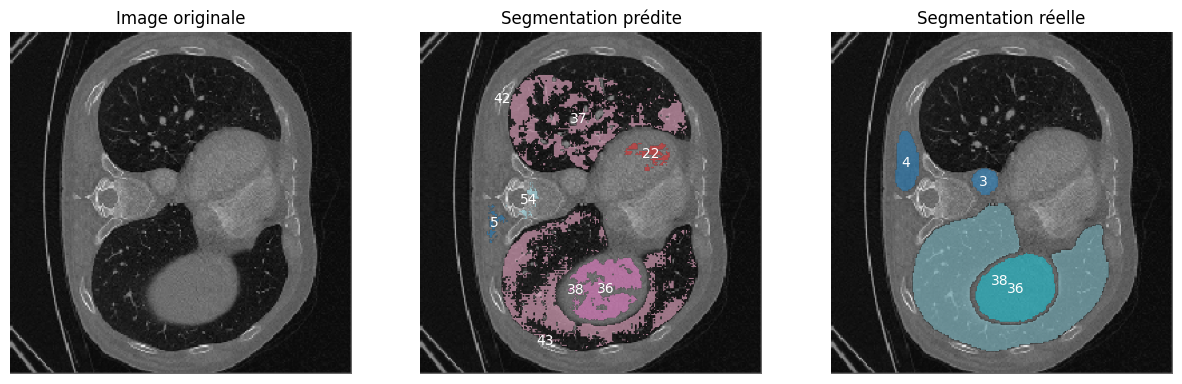

In [32]:
# Fonction pour afficher une image, sa prédiction et son label réel
def plot_slice_seg(image, pred, label, idx=0):
    """
    Affiche une image en niveaux de gris avec la segmentation prédite et la segmentation réelle.

    image : image originale (3D ou 2D)
    pred  : prédiction du modèle (2D, classes)
    label : ground truth (2D, classes)
    idx   : index de l'exemple à afficher
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Affichage de l'image originale
    axes[0].imshow(image[idx % image.shape[0]].squeeze(), cmap="gray") # Use modulo operator to ensure idx is within bounds
    axes[0].set_title("Image originale")

    # Affichage de la prédiction
    pred_masked = np.ma.masked_where(pred[idx % pred.shape[0]] == 0, pred[idx % pred.shape[0]])  # Masquer le fond (classe 0) # Use modulo operator to ensure idx is within bounds
    axes[1].imshow(image[idx % image.shape[0]].squeeze(), cmap="gray") # Use modulo operator to ensure idx is within bounds
    axes[1].imshow(pred_masked, cmap="tab20", alpha=0.6)
    axes[1].set_title("Segmentation prédite")

    # Affichage du label réel
    label_masked = np.ma.masked_where(label[idx % label.shape[0]] == 0, label[idx % label.shape[0]]) # Use modulo operator to ensure idx is within bounds
    axes[2].imshow(image[idx % image.shape[0]].squeeze(), cmap="gray") # Use modulo operator to ensure idx is within bounds
    axes[2].imshow(label_masked, cmap="tab20", alpha=0.6)
    axes[2].set_title("Segmentation réelle")

    # Ajout des numéros de classe
    for i in range(1, NUM_CLASSES + 1): # On ignore le fond (classe 0)
        # Trouver les coordonnées des pixels appartenant à la classe i
        pred_coords = np.argwhere(pred[idx % pred.shape[0]] == i)
        label_coords = np.argwhere(label[idx % label.shape[0]] == i)

        # Afficher le numéro de classe au centre de la zone (approximativement)
        if len(pred_coords) > 0:
            center_pred = pred_coords.mean(axis=0).astype(int)
            axes[1].text(center_pred[1], center_pred[0], str(i), color='white', ha='center', va='center')
        if len(label_coords) > 0:
            center_label = label_coords.mean(axis=0).astype(int)
            axes[2].text(center_label[1], center_label[0], str(i), color='white', ha='center', va='center')


    for ax in axes:
        ax.axis("off")

    plt.show()

# Sélectionner un index aléatoire pour visualiser un exemple de validation
idx = np.random.randint(len(train_dataset_2)-1)  # Si val_dataset est ta liste d'images de validation

# Get a batch of images, labels, and features from the validation loader at the random index
image, label, feature = train_dataset_2[idx]
image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
feature = feature.unsqueeze(0).to(device)  # Add batch dimension and move to device

with torch.no_grad():
    output = model_swin_both(image)  # Get the model's prediction
    pred = torch.argmax(output, dim=1).cpu().numpy()  # Get the predicted class labels

plot_slice_seg(
    image.cpu().numpy(),  # Images d'entrée (tensor → NumPy)
    pred,  # Prédictions (déjà en NumPy)
    label.unsqueeze(0).numpy(),  # Labels réels (déjà en NumPy) # Add batch dimension
    idx  # Index to use for plotting (always 0 since we're using a single image)
)

In [33]:
torch.cuda.empty_cache()

## MODEL WITH IMAGES AND FEATURES

In [36]:
import torch
import torch.nn as nn
from monai.networks.nets import SwinUNETR

class FILM(nn.Module):
    def __init__(self, feature_dim):
        super(FILM, self).__init__()
        self.feature_dim = feature_dim

    def forward(self, x, features):
        num_channels = x.size(1)  # Nombre de canaux dans x
        fc = nn.Linear(self.feature_dim, 2 * num_channels).to(x.device)  # Couche FC dynamique
        params = fc(features)  # [B, 2 * C]
        gamma, beta = params.chunk(2, dim=1)  # [B, C], [B, C]
        gamma = gamma.unsqueeze(-1).unsqueeze(-1)  # [B, C, 1, 1]
        beta = beta.unsqueeze(-1).unsqueeze(-1)    # [B, C, 1, 1]
        gamma = gamma + 1.0 
        beta = beta * 0.1   
        return x * gamma + beta  # Modulation


class SwinUNETRWithFILM(nn.Module):
    def __init__(self, img_size, in_channels, out_channels, feature_dim, use_checkpoint=True, spatial_dims=2):
        super(SwinUNETRWithFILM, self).__init__()
        self.swin_unetr = SwinUNETR(
            img_size=img_size,
            in_channels=in_channels,
            out_channels=out_channels,
            use_checkpoint=use_checkpoint,
            spatial_dims=spatial_dims,
        )
        self.film = FILM(feature_dim)

    def forward(self, x, features):
        features = features.mean(dim=[2, 3])  # Global Average Pooling pour obtenir [B, 768]
        x = self.swin_unetr(x)  # Passer x à travers Swin UNETR
        x = self.film(x, features)  # Appliquer FILM
        return x

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialisation du modèle
model_with_features = SwinUNETRWithFILM(
    img_size=(256, 256),
    in_channels=1,
    out_channels=NUM_CLASSES+1,
    feature_dim=768,
    use_checkpoint=True,
    spatial_dims=2,
).to(device)

c:\Users\yanni\anaconda3\lib\site-packages\monai\utils\deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


In [ ]:
from monai.networks.nets import SwinUNETR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.backends.cudnn.benchmark = True
ce_loss = nn.CrossEntropyLoss()
#dice_loss = DiceLoss(NUM_CLASSES+1)
optimizer = optim.AdamW(model_with_features.parameters(), lr=0.005, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

# Boucle d'entraînement simple
num_epochs = 1000  # Ajuste selon tes besoins
losses = []
val_losses = []
counter = 0  # Compteur d'époques sans amélioration
patience = 20  # Nombre d'époques sans amélioration avant d'arrêter
best_val_loss = float('inf')

for epoch in tqdm(range(num_epochs)):
    model_with_features.train()
    running_loss = 0.0

    for images, labels, features in train_loader_1:
        images, labels, features = images.to(device), labels.to(device), features.to(device)
        features = (features - features.mean()) / features.std()  # Normalisation des features

        optimizer.zero_grad()
        outputs = model_with_features(images, features)

        loss_ce = ce_loss(outputs, labels)
        loss_dice = 1-dice_torch(torch.argmax(outputs, dim=1), labels, NUM_CLASSES+1)
        loss = 0.4 * loss_ce + 0.6 * loss_dice
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    losses.append(running_loss / len(train_loader_1))
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader_1):.4f}")

    # ---- ÉVALUATION ----
    model_with_features.eval()  # Met le modèle en mode évaluation

    val_loss = 0.0  # Variable pour accumuler la perte de validation
    with torch.no_grad():
        for images, labels, features in val_loader:
            images, labels, features = images.to(device), labels.to(device), features.to(device)
            features = (features - features.mean()) / features.std()  # Normalisation des features

            # Passer les images dans le modèle
            outputs = model_with_features(images, features)

            # Calcul de la CrossEntropyLoss
            loss_dice = 1-dice_torch(torch.argmax(outputs, dim=1), labels, NUM_CLASSES+1)
            val_loss +=  loss_dice

    # Moyenne de la perte de validation
    val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {val_loss:.4f}")

    # Optionnel : afficher la progression de la perte de validation
    val_losses.append(val_loss)

    # Sauvegarder le modèle si la perte de validation est la meilleure vue jusqu'à présent
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_with_features.state_dict(), "best_model_with_features.pth")
        counter = 0
    else:
        counter += 1
    if counter == patience:
        print(f"Arrêt prématuré à l'époque {epoch+1}")
        break

C:\Users\yanni\AppData\Local\Temp\ipykernel_19208\312435478.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/1000], Loss: 0.8180


  0%|          | 1/1000 [00:58<16:10:54, 58.31s/it]

Validation Loss: 0.9712
Epoch [2/1000], Loss: 0.8055


  0%|          | 2/1000 [01:55<15:54:55, 57.41s/it]

Validation Loss: 0.9845
Epoch [3/1000], Loss: 0.7840


  0%|          | 3/1000 [02:52<15:50:51, 57.22s/it]

Validation Loss: 0.9587
Epoch [4/1000], Loss: 0.7782


  0%|          | 4/1000 [03:48<15:47:08, 57.06s/it]

Validation Loss: 0.9694
Epoch [5/1000], Loss: 0.7720


  0%|          | 5/1000 [04:45<15:45:45, 57.03s/it]

Validation Loss: 0.9746
Epoch [6/1000], Loss: 0.7618


  1%|          | 6/1000 [05:42<15:44:55, 57.04s/it]

Validation Loss: 0.9623
Epoch [7/1000], Loss: 0.7674


  1%|          | 7/1000 [06:40<15:47:59, 57.28s/it]

Validation Loss: 0.9789
Epoch [8/1000], Loss: 0.7554


  1%|          | 8/1000 [07:37<15:45:56, 57.21s/it]

Validation Loss: 0.9615
Epoch [9/1000], Loss: 0.7581


  1%|          | 9/1000 [08:35<15:45:18, 57.23s/it]

Validation Loss: 0.9498
Epoch [10/1000], Loss: 0.7484


  1%|          | 10/1000 [09:32<15:44:22, 57.24s/it]

Validation Loss: 0.9577
Epoch [11/1000], Loss: 0.7385


  1%|          | 11/1000 [10:29<15:42:06, 57.15s/it]

Validation Loss: 0.9593
Epoch [12/1000], Loss: 0.7367


  1%|          | 12/1000 [11:26<15:39:46, 57.07s/it]

Validation Loss: 0.9560
Epoch [13/1000], Loss: 0.7402


  1%|▏         | 13/1000 [12:23<15:37:43, 57.01s/it]

Validation Loss: 0.9568
Epoch [14/1000], Loss: 0.7359


  1%|▏         | 14/1000 [13:20<15:36:59, 57.02s/it]

Validation Loss: 0.9365
Epoch [15/1000], Loss: 0.7447


  2%|▏         | 15/1000 [14:17<15:38:44, 57.18s/it]

Validation Loss: 0.9603
Epoch [16/1000], Loss: 0.7239


  2%|▏         | 16/1000 [15:14<15:36:40, 57.11s/it]

Validation Loss: 0.9390
Epoch [17/1000], Loss: 0.7318


  2%|▏         | 17/1000 [16:11<15:35:19, 57.09s/it]

Validation Loss: 0.9524
Epoch [18/1000], Loss: 0.7245


  2%|▏         | 18/1000 [17:08<15:34:01, 57.07s/it]

Validation Loss: 0.9591
Epoch [19/1000], Loss: 0.7279


  2%|▏         | 19/1000 [18:05<15:32:26, 57.03s/it]

Validation Loss: 0.9440
Epoch [20/1000], Loss: 0.7217


  2%|▏         | 20/1000 [19:02<15:32:44, 57.11s/it]

Validation Loss: 0.9528
Epoch [21/1000], Loss: 0.7242


  2%|▏         | 21/1000 [19:59<15:30:35, 57.03s/it]

Validation Loss: 0.9466
Epoch [22/1000], Loss: 0.7203


  2%|▏         | 22/1000 [20:56<15:27:31, 56.90s/it]

Validation Loss: 0.9461
Epoch [23/1000], Loss: 0.7232


  2%|▏         | 23/1000 [21:52<15:24:47, 56.79s/it]

Validation Loss: 0.9495
Epoch [24/1000], Loss: 0.7201


  2%|▏         | 24/1000 [22:49<15:24:27, 56.83s/it]

Validation Loss: 0.9345
Epoch [25/1000], Loss: 0.7072


  2%|▎         | 25/1000 [23:46<15:22:06, 56.74s/it]

Validation Loss: 0.9492
Epoch [26/1000], Loss: 0.7150


  3%|▎         | 26/1000 [24:42<15:20:10, 56.68s/it]

Validation Loss: 0.9367
Epoch [27/1000], Loss: 0.7195


  3%|▎         | 27/1000 [25:39<15:18:24, 56.63s/it]

Validation Loss: 0.9401
Epoch [28/1000], Loss: 0.7086


  3%|▎         | 28/1000 [26:35<15:16:09, 56.55s/it]

Validation Loss: 0.9452
Epoch [29/1000], Loss: 0.7045


  3%|▎         | 29/1000 [27:32<15:16:26, 56.63s/it]

Validation Loss: 0.9482
Epoch [30/1000], Loss: 0.7071


  3%|▎         | 30/1000 [28:28<15:14:06, 56.54s/it]

Validation Loss: 0.9545
Epoch [31/1000], Loss: 0.7004


  3%|▎         | 31/1000 [29:25<15:14:50, 56.65s/it]

Validation Loss: 0.9429
Epoch [32/1000], Loss: 0.6964


  3%|▎         | 32/1000 [30:23<15:19:01, 56.96s/it]

Validation Loss: 0.9256
Epoch [33/1000], Loss: 0.7002


  3%|▎         | 33/1000 [31:20<15:16:12, 56.85s/it]

Validation Loss: 0.9490
Epoch [34/1000], Loss: 0.7029


  3%|▎         | 34/1000 [32:16<15:12:51, 56.70s/it]

Validation Loss: 0.9383
Epoch [35/1000], Loss: 0.7025


  4%|▎         | 35/1000 [33:12<15:11:07, 56.65s/it]

Validation Loss: 0.9360
Epoch [36/1000], Loss: 0.6927


  4%|▎         | 36/1000 [34:09<15:09:51, 56.63s/it]

Validation Loss: 0.9452
Epoch [37/1000], Loss: 0.6960


  4%|▎         | 37/1000 [35:06<15:08:28, 56.60s/it]

Validation Loss: 0.9268
Epoch [38/1000], Loss: 0.6993


  4%|▍         | 38/1000 [36:02<15:08:03, 56.64s/it]

Validation Loss: 0.9428
Epoch [39/1000], Loss: 0.7012


  4%|▍         | 39/1000 [36:59<15:06:27, 56.59s/it]

Validation Loss: 0.9341
Epoch [40/1000], Loss: 0.6932


  4%|▍         | 40/1000 [37:55<15:04:54, 56.56s/it]

Validation Loss: 0.9322
Epoch [41/1000], Loss: 0.6950


  4%|▍         | 41/1000 [38:52<15:04:21, 56.58s/it]

Validation Loss: 0.9511
Epoch [42/1000], Loss: 0.6833


  4%|▍         | 42/1000 [39:48<15:02:50, 56.55s/it]

Validation Loss: 0.9314
Epoch [43/1000], Loss: 0.6919


  4%|▍         | 43/1000 [40:45<15:02:01, 56.55s/it]

Validation Loss: 0.9347
Epoch [44/1000], Loss: 0.6896


  4%|▍         | 44/1000 [41:42<15:01:33, 56.58s/it]

Validation Loss: 0.9276
Epoch [45/1000], Loss: 0.6860


  4%|▍         | 45/1000 [42:38<15:01:00, 56.61s/it]

Validation Loss: 0.9363
Epoch [46/1000], Loss: 0.6820


  5%|▍         | 46/1000 [43:35<14:59:58, 56.60s/it]

Validation Loss: 0.9110
Epoch [47/1000], Loss: 0.6816


  5%|▍         | 47/1000 [44:32<15:00:13, 56.68s/it]

Validation Loss: 0.9099
Epoch [48/1000], Loss: 0.6808


  5%|▍         | 48/1000 [45:28<14:58:56, 56.66s/it]

Validation Loss: 0.9372
Epoch [49/1000], Loss: 0.6867


  5%|▍         | 49/1000 [46:25<14:57:20, 56.61s/it]

Validation Loss: 0.9212
Epoch [50/1000], Loss: 0.6809


  5%|▌         | 50/1000 [47:21<14:56:28, 56.62s/it]

Validation Loss: 0.9395
Epoch [51/1000], Loss: 0.6768


  5%|▌         | 51/1000 [48:18<14:56:12, 56.66s/it]

Validation Loss: 0.9093
Epoch [52/1000], Loss: 0.6800


  5%|▌         | 52/1000 [49:15<14:55:26, 56.67s/it]

Validation Loss: 0.9320
Epoch [53/1000], Loss: 0.6800


  5%|▌         | 53/1000 [50:12<14:55:33, 56.74s/it]

Validation Loss: 0.9239
Epoch [54/1000], Loss: 0.6758


  5%|▌         | 54/1000 [51:09<14:58:39, 57.00s/it]

Validation Loss: 0.9318
Epoch [55/1000], Loss: 0.6799


  6%|▌         | 55/1000 [52:08<15:04:11, 57.41s/it]

Validation Loss: 0.9380
Epoch [56/1000], Loss: 0.6690


  6%|▌         | 56/1000 [53:07<15:10:56, 57.90s/it]

Validation Loss: 0.9342
Epoch [57/1000], Loss: 0.6770


  6%|▌         | 57/1000 [54:09<15:30:15, 59.19s/it]

Validation Loss: 0.9236
Epoch [58/1000], Loss: 0.6754


  6%|▌         | 58/1000 [55:08<15:28:56, 59.17s/it]

Validation Loss: 0.9154
Epoch [59/1000], Loss: 0.6771


  6%|▌         | 59/1000 [56:08<15:31:06, 59.37s/it]

Validation Loss: 0.9416
Epoch [60/1000], Loss: 0.6672


  6%|▌         | 60/1000 [57:06<15:23:08, 58.92s/it]

Validation Loss: 0.9159
Epoch [61/1000], Loss: 0.6757


  6%|▌         | 61/1000 [58:04<15:16:59, 58.59s/it]

Validation Loss: 0.9319
Epoch [62/1000], Loss: 0.6670


  6%|▌         | 62/1000 [59:02<15:12:28, 58.37s/it]

Validation Loss: 0.9242
Epoch [63/1000], Loss: 0.6742


  6%|▋         | 63/1000 [1:00:00<15:10:59, 58.33s/it]

Validation Loss: 0.9264
Epoch [64/1000], Loss: 0.6737


  6%|▋         | 64/1000 [1:01:02<15:26:58, 59.42s/it]

Validation Loss: 0.9352
Epoch [65/1000], Loss: 0.6628


  6%|▋         | 65/1000 [1:01:59<15:17:39, 58.89s/it]

Validation Loss: 0.9196
Epoch [66/1000], Loss: 0.6688


  7%|▋         | 66/1000 [1:02:57<15:09:20, 58.42s/it]

Validation Loss: 0.9268
Epoch [67/1000], Loss: 0.6650


  7%|▋         | 67/1000 [1:03:57<15:19:01, 59.10s/it]

Validation Loss: 0.9251
Epoch [68/1000], Loss: 0.6721


  7%|▋         | 68/1000 [1:04:57<15:19:35, 59.20s/it]

Validation Loss: 0.9208
Epoch [69/1000], Loss: 0.6615
Validation Loss: 0.9063


  7%|▋         | 69/1000 [1:05:54<15:10:15, 58.66s/it]

Epoch [70/1000], Loss: 0.6643


  7%|▋         | 70/1000 [1:06:51<15:02:28, 58.22s/it]

Validation Loss: 0.9279
Epoch [71/1000], Loss: 0.6618


  7%|▋         | 71/1000 [1:07:49<14:57:13, 57.95s/it]

Validation Loss: 0.9344
Epoch [72/1000], Loss: 0.6640


  7%|▋         | 72/1000 [1:08:46<14:52:51, 57.73s/it]

Validation Loss: 0.9167
Epoch [73/1000], Loss: 0.6638


  7%|▋         | 73/1000 [1:09:43<14:50:11, 57.62s/it]

Validation Loss: 0.9117
Epoch [74/1000], Loss: 0.6568


  7%|▋         | 74/1000 [1:10:41<14:48:49, 57.59s/it]

Validation Loss: 0.9114
Epoch [75/1000], Loss: 0.6599


  8%|▊         | 75/1000 [1:11:38<14:44:50, 57.40s/it]

Validation Loss: 0.9205
Epoch [76/1000], Loss: 0.6661


  8%|▊         | 76/1000 [1:12:34<14:39:55, 57.14s/it]

Validation Loss: 0.9156
Epoch [77/1000], Loss: 0.6562


  8%|▊         | 77/1000 [1:13:31<14:38:39, 57.12s/it]

Validation Loss: 0.9028
Epoch [78/1000], Loss: 0.6565


  8%|▊         | 78/1000 [1:14:28<14:35:31, 56.98s/it]

Validation Loss: 0.9107
Epoch [79/1000], Loss: 0.6617


  8%|▊         | 79/1000 [1:15:25<14:33:03, 56.88s/it]

Validation Loss: 0.9323
Epoch [80/1000], Loss: 0.6523


  8%|▊         | 80/1000 [1:16:22<14:32:17, 56.89s/it]

Validation Loss: 0.9129


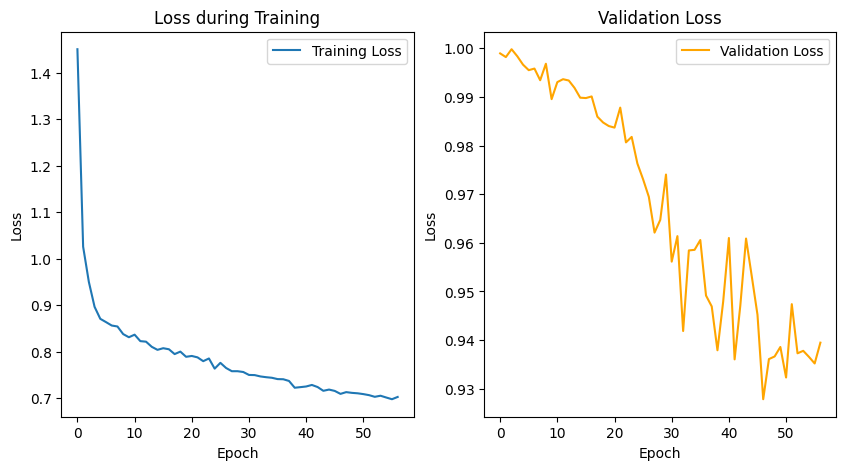

In [42]:

# ---- GRAPHIQUES ----
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss during Training")
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_losses, label="Validation Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.legend()

plt.show()

In [43]:
model_with_features.eval()  # Met le modèle en mode évaluation

eval = 0.0
with torch.no_grad():
    for images, labels, features in val_loader:
        images, labels, features = images.to(device), labels.to(device), features.to(device)

        # Passer les images dans le modèle
        outputs = model_with_features(images, features)

        # Obtenir les prédictions en prenant l'argmax sur la dimension des classes
        preds = torch.argmax(outputs, dim=1)
        eval += dice_torch(preds, labels, NUM_CLASSES+1)
    dice_score_with_features = eval / len(val_loader)

print(f"Validation Dice Score: {dice_score_with_features:.4f}")

Validation Dice Score: 0.0419


In [57]:
torch.cuda.empty_cache()

In [ ]:
import torch
import torch.nn as nn
from monai.networks.nets import SwinUNETR

class FILM(nn.Module):
    def __init__(self, feature_dim):
        super(FILM, self).__init__()
        self.feature_dim = feature_dim

    def forward(self, x, features):
        num_channels = x.size(1)  # Nombre de canaux dans x
        fc = nn.Linear(self.feature_dim, 2 * num_channels).to(x.device)  # Couche FC dynamique
        params = fc(features)  # [B, 2 * C]
        gamma, beta = params.chunk(2, dim=1)  # [B, C], [B, C]
        gamma = gamma.unsqueeze(-1).unsqueeze(-1)  # [B, C, 1, 1]
        beta = beta.unsqueeze(-1).unsqueeze(-1)    # [B, C, 1, 1]
        gamma = gamma + 1.0 
        beta = beta * 0.1   
        return x * gamma + beta  # Modulation


class SwinUNETRWithFILM(nn.Module):
    def __init__(self, img_size, in_channels, out_channels, feature_dim, use_checkpoint=True, spatial_dims=2):
        super(SwinUNETRWithFILM, self).__init__()
        self.swin_unetr = SwinUNETR(
            img_size=img_size,
            in_channels=in_channels,
            out_channels=out_channels,
            use_checkpoint=use_checkpoint,
            spatial_dims=spatial_dims,
        )
        self.film = FILM(feature_dim)

    def forward(self, x, features):
        features = features.mean(dim=[2, 3])  # Global Average Pooling pour obtenir [B, 768]
        x = self.swin_unetr(x)  # Passer x à travers Swin UNETR
        x = self.film(x, features)  # Appliquer FILM
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialisation du modèle
model_with_features = SwinUNETRWithFILM(
    img_size=(256, 256),
    in_channels=1,
    out_channels=NUM_CLASSES+1,
    feature_dim=768,
    use_checkpoint=True,
    spatial_dims=2,
).to(device)

model_with_features.load_state_dict(torch.load("best_model_with_features.pth"))

<All keys matched successfully>

In [28]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm

# Function to get predictions
def get_predictions(model, dataloader, device):
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for images, features in tqdm(dataloader, desc="Generating predictions"):
            images, features = images.to(device), features.to(device)
            outputs = model(images, features)  # Output shape: (batch_size, num_classes, 256, 256)
            preds = torch.argmax(outputs, dim=1)  # Get the most probable class
            predictions.append(preds.cpu().numpy())  # Convert to numpy

    return np.concatenate(predictions, axis=0)  # Final shape: (N, 256, 256)

# Get predictions on the test set
predictions_test = get_predictions(model_with_features, test_loader, device)  # Shape: (N, 256, 256)
print("Predictions shape:", predictions_test.shape)

# Reshape predictions to have one row per pixel (instead of image)
n_images = predictions_test.shape[0]  # Number of images
n_pixels = 256 * 256  # Total number of pixels (256 * 256)

# Correct reshaping: each row represents a pixel, and each column an image
predictions_flat = predictions_test.transpose(1, 2, 0).reshape(n_pixels, n_images)  # Shape: (256*256, N)

# Create DataFrame
columns = [f"{i}.png" for i in range(n_images)]
df = pd.DataFrame(predictions_flat, columns=columns)  # Each column is an image

# Add a 'Pixel' column for each row representing pixel positions
df.insert(0, "Pixel", [f"Pixel {i}" for i in range(n_pixels)])

# Save to CSV with proper formatting
df.to_csv("predictions_with_features.csv", index=False, encoding='utf-8')
print("CSV file saved successfully!")

Generating predictions:   0%|          | 0/125 [00:00<?, ?it/s]

Generating predictions: 100%|██████████| 125/125 [00:11<00:00, 10.67it/s]


Predictions shape: (500, 256, 256)
CSV file saved successfully!


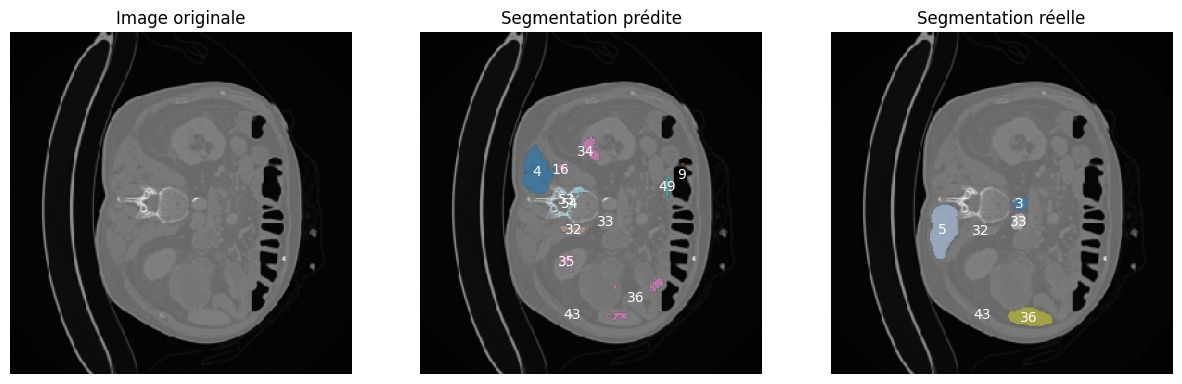

In [30]:
# Fonction pour afficher une image, sa prédiction et son label réel
def plot_slice_seg(image, pred, label, idx=0):
    """
    Affiche une image en niveaux de gris avec la segmentation prédite et la segmentation réelle.

    image : image originale (3D ou 2D)
    pred  : prédiction du modèle (2D, classes)
    label : ground truth (2D, classes)
    idx   : index de l'exemple à afficher
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Affichage de l'image originale
    axes[0].imshow(image[idx % image.shape[0]].squeeze(), cmap="gray") # Use modulo operator to ensure idx is within bounds
    axes[0].set_title("Image originale")

    # Affichage de la prédiction
    pred_masked = np.ma.masked_where(pred[idx % pred.shape[0]] == 0, pred[idx % pred.shape[0]])  # Masquer le fond (classe 0) # Use modulo operator to ensure idx is within bounds
    axes[1].imshow(image[idx % image.shape[0]].squeeze(), cmap="gray") # Use modulo operator to ensure idx is within bounds
    axes[1].imshow(pred_masked, cmap="tab20", alpha=0.6)
    axes[1].set_title("Segmentation prédite")

    # Affichage du label réel
    label_masked = np.ma.masked_where(label[idx % label.shape[0]] == 0, label[idx % label.shape[0]]) # Use modulo operator to ensure idx is within bounds
    axes[2].imshow(image[idx % image.shape[0]].squeeze(), cmap="gray") # Use modulo operator to ensure idx is within bounds
    axes[2].imshow(label_masked, cmap="tab20", alpha=0.6)
    axes[2].set_title("Segmentation réelle")

    # Ajout des numéros de classe
    for i in range(1, NUM_CLASSES + 1): # On ignore le fond (classe 0)
        # Trouver les coordonnées des pixels appartenant à la classe i
        pred_coords = np.argwhere(pred[idx % pred.shape[0]] == i)
        label_coords = np.argwhere(label[idx % label.shape[0]] == i)

        # Afficher le numéro de classe au centre de la zone (approximativement)
        if len(pred_coords) > 0:
            center_pred = pred_coords.mean(axis=0).astype(int)
            axes[1].text(center_pred[1], center_pred[0], str(i), color='white', ha='center', va='center')
        if len(label_coords) > 0:
            center_label = label_coords.mean(axis=0).astype(int)
            axes[2].text(center_label[1], center_label[0], str(i), color='white', ha='center', va='center')


    for ax in axes:
        ax.axis("off")

    plt.show()

# Sélectionner un index aléatoire pour visualiser un exemple de validation
idx = np.random.randint(len(train_dataset_2)-1)  # Si val_dataset est ta liste d'images de validation

# Get a batch of images, labels, and features from the validation loader at the random index
image, label, feature = train_dataset_2[idx]
image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
feature = feature.unsqueeze(0).to(device)  # Add batch dimension and move to device

with torch.no_grad():
    output = model_with_features(image, feature)  # Get the model's prediction
    pred = torch.argmax(output, dim=1).cpu().numpy()  # Get the predicted class labels

plot_slice_seg(
    image.cpu().numpy(),  # Images d'entrée (tensor → NumPy)
    pred,  # Prédictions (déjà en NumPy)
    label.unsqueeze(0).numpy(),  # Labels réels (déjà en NumPy) # Add batch dimension
    idx  # Index to use for plotting (always 0 since we're using a single image)
)

## MODEL WITH FINE-TUNING 

In [25]:
from monai.networks.nets import SwinUNETR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Change img_size to match the actual image size (256, 256)
model_pre_training= SwinUNETR(
    img_size=(256, 256),  # Match the actual input image size
    in_channels=1,  # Images CT-scan en niveaux de gris
    out_channels=NUM_CLASSES+1,  # Nombre de classes
    use_checkpoint=True,  # Gradient checkpointing pour économiser la mémoire
    spatial_dims=2,  # Important pour utiliser la version 2D
).to(device)

torch.backends.cudnn.benchmark = True
ce_loss = nn.CrossEntropyLoss()
dice_loss = DiceLoss(NUM_CLASSES+1)
optimizer = optim.AdamW(model_pre_training.parameters(), lr=0.0005, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

# Boucle d'entraînement simple
num_epochs = 100  # Ajuste selon tes besoins
losses = []
val_losses = []
counter = 0  # Compteur d'époques sans amélioration
patience = 10  # Nombre d'époques sans amélioration avant d'arrêter
best_val_loss = float('inf')

for epoch in tqdm(range(num_epochs)):
    model_pre_training.train()
    running_loss = 0.0

    for images, labels, features in train_loader_1:
        images, labels, features = images.to(device), labels.to(device), features

        optimizer.zero_grad()
        outputs = model_pre_training(images)

        loss_ce = ce_loss(outputs, labels)
        loss_dice = dice_loss(outputs, labels, softmax=True)
        loss = 0.4 * loss_ce + 0.6 * loss_dice
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    losses.append(running_loss / len(train_loader_1))
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader_1):.4f}")

    # ---- ÉVALUATION ----
    model_pre_training.eval()  # Met le modèle en mode évaluation

    val_loss = 0.0  # Variable pour accumuler la perte de validation
    with torch.no_grad():
        for images, labels, features in val_loader:
            images, labels, features = images.to(device), labels.to(device), features.to(device)

            # Passer les images dans le modèle
            outputs = model_pre_training(images)

            # Calcul de la CrossEntropyLoss
            loss_dice = dice_loss(outputs, labels, softmax=True)
            val_loss +=  loss_dice

    # Moyenne de la perte de validation
    val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {val_loss:.4f}")

    # Optionnel : afficher la progression de la perte de validation
    val_losses.append(val_loss)

    # Sauvegarder le modèle si la perte de validation est la meilleure vue jusqu'à présent
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_pre_training.state_dict(), "best_model_pre_training.pth")
        counter = 0
    else:
        counter += 1
    if counter == patience:
        print(f"Arrêt prématuré à l'époque {epoch+1}")
        break

C:\Users\yanni\AppData\Local\Temp\ipykernel_14976\1446982868.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
  0%|          | 0/80 [00:00<?, ?it/s]

Epoch [1/80], Loss: 1.9772


  1%|▏         | 1/80 [00:45<59:56, 45.53s/it]

Validation Loss: 0.9855
Epoch [2/80], Loss: 1.7008


  2%|▎         | 2/80 [01:30<58:45, 45.19s/it]

Validation Loss: 0.9837
Epoch [3/80], Loss: 1.4946


  4%|▍         | 3/80 [02:15<57:57, 45.17s/it]

Validation Loss: 0.9811
Epoch [4/80], Loss: 1.3028


  5%|▌         | 4/80 [03:16<1:04:55, 51.25s/it]

Validation Loss: 0.9783
Epoch [5/80], Loss: 1.1409


  6%|▋         | 5/80 [04:01<1:01:21, 49.09s/it]

Validation Loss: 0.9759
Epoch [6/80], Loss: 1.0326


  8%|▊         | 6/80 [04:46<58:56, 47.79s/it]  

Validation Loss: 0.9744
Epoch [7/80], Loss: 0.9534


  9%|▉         | 7/80 [05:32<57:09, 46.98s/it]

Validation Loss: 0.9736
Epoch [8/80], Loss: 0.9039


 10%|█         | 8/80 [06:17<55:43, 46.44s/it]

Validation Loss: 0.9707
Epoch [9/80], Loss: 0.8711


 11%|█▏        | 9/80 [07:02<54:34, 46.12s/it]

Validation Loss: 0.9698
Epoch [10/80], Loss: 0.8469


 12%|█▎        | 10/80 [07:48<53:33, 45.90s/it]

Validation Loss: 0.9691
Epoch [11/80], Loss: 0.8311


 14%|█▍        | 11/80 [08:34<52:49, 45.94s/it]

Validation Loss: 0.9688
Epoch [12/80], Loss: 0.8147


 15%|█▌        | 12/80 [09:19<51:52, 45.78s/it]

Validation Loss: 0.9674
Epoch [13/80], Loss: 0.8052


 16%|█▋        | 13/80 [10:04<50:57, 45.64s/it]

Validation Loss: 0.9659
Epoch [14/80], Loss: 0.7965


 18%|█▊        | 14/80 [10:51<50:32, 45.95s/it]

Validation Loss: 0.9669
Epoch [15/80], Loss: 0.7904


 19%|█▉        | 15/80 [11:36<49:34, 45.76s/it]

Validation Loss: 0.9606
Epoch [16/80], Loss: 0.7845


 20%|██        | 16/80 [12:22<48:40, 45.63s/it]

Validation Loss: 0.9597
Epoch [17/80], Loss: 0.7781


 21%|██▏       | 17/80 [13:07<47:46, 45.51s/it]

Validation Loss: 0.9596
Epoch [18/80], Loss: 0.7736


 22%|██▎       | 18/80 [13:52<46:59, 45.47s/it]

Validation Loss: 0.9590
Epoch [19/80], Loss: 0.7694


 24%|██▍       | 19/80 [14:38<46:12, 45.46s/it]

Validation Loss: 0.9575
Epoch [20/80], Loss: 0.7644


 25%|██▌       | 20/80 [15:23<45:30, 45.50s/it]

Validation Loss: 0.9539
Epoch [21/80], Loss: 0.7616


 26%|██▋       | 21/80 [16:04<43:19, 44.06s/it]

Validation Loss: 0.9535
Epoch [22/80], Loss: 0.7549


 28%|██▊       | 22/80 [16:40<40:07, 41.51s/it]

Validation Loss: 0.9499
Epoch [23/80], Loss: 0.7495


 29%|██▉       | 23/80 [17:16<37:55, 39.91s/it]

Validation Loss: 0.9478
Epoch [24/80], Loss: 0.7447


 30%|███       | 24/80 [17:52<36:08, 38.73s/it]

Validation Loss: 0.9432
Epoch [25/80], Loss: 0.7404


 31%|███▏      | 25/80 [18:27<34:39, 37.82s/it]

Validation Loss: 0.9383
Epoch [26/80], Loss: 0.7338


 32%|███▎      | 26/80 [19:04<33:44, 37.50s/it]

Validation Loss: 0.9383
Epoch [27/80], Loss: 0.7308


 34%|███▍      | 27/80 [19:41<32:54, 37.25s/it]

Validation Loss: 0.9350
Epoch [28/80], Loss: 0.7256


 35%|███▌      | 28/80 [20:16<31:49, 36.72s/it]

Validation Loss: 0.9392
Epoch [29/80], Loss: 0.7238


 36%|███▋      | 29/80 [20:55<31:36, 37.19s/it]

Validation Loss: 0.9302
Epoch [30/80], Loss: 0.7152


 38%|███▊      | 30/80 [21:30<30:38, 36.77s/it]

Validation Loss: 0.9292
Epoch [31/80], Loss: 0.7130


 39%|███▉      | 31/80 [22:06<29:46, 36.46s/it]

Validation Loss: 0.9284
Epoch [32/80], Loss: 0.7095


 40%|████      | 32/80 [22:42<29:02, 36.31s/it]

Validation Loss: 0.9236
Epoch [33/80], Loss: 0.7060


 41%|████▏     | 33/80 [23:18<28:21, 36.20s/it]

Validation Loss: 0.9272
Epoch [34/80], Loss: 0.7070


 42%|████▎     | 34/80 [23:54<27:38, 36.05s/it]

Validation Loss: 0.9217
Epoch [35/80], Loss: 0.7006


 44%|████▍     | 35/80 [24:29<26:55, 35.90s/it]

Validation Loss: 0.9189
Epoch [36/80], Loss: 0.6938


 45%|████▌     | 36/80 [25:05<26:15, 35.80s/it]

Validation Loss: 0.9195
Epoch [37/80], Loss: 0.6920


 46%|████▋     | 37/80 [25:40<25:35, 35.72s/it]

Validation Loss: 0.9155
Epoch [38/80], Loss: 0.6865


 48%|████▊     | 38/80 [26:16<25:01, 35.75s/it]

Validation Loss: 0.9116
Epoch [39/80], Loss: 0.6810


 49%|████▉     | 39/80 [26:52<24:24, 35.73s/it]

Validation Loss: 0.9099
Epoch [40/80], Loss: 0.6808


 50%|█████     | 40/80 [27:27<23:47, 35.68s/it]

Validation Loss: 0.9055
Epoch [41/80], Loss: 0.6800


 51%|█████▏    | 41/80 [28:03<23:09, 35.64s/it]

Validation Loss: 0.9083
Epoch [42/80], Loss: 0.6746


 52%|█████▎    | 42/80 [28:39<22:33, 35.62s/it]

Validation Loss: 0.9030
Epoch [43/80], Loss: 0.6707


 54%|█████▍    | 43/80 [29:15<22:11, 35.99s/it]

Validation Loss: 0.9016
Epoch [44/80], Loss: 0.6649


 55%|█████▌    | 44/80 [29:51<21:28, 35.79s/it]

Validation Loss: 0.8982
Epoch [45/80], Loss: 0.6618


 56%|█████▋    | 45/80 [30:26<20:50, 35.74s/it]

Validation Loss: 0.8979
Epoch [46/80], Loss: 0.6606


 57%|█████▊    | 46/80 [31:02<20:14, 35.72s/it]

Validation Loss: 0.8954
Epoch [47/80], Loss: 0.6558


 59%|█████▉    | 47/80 [31:38<19:40, 35.78s/it]

Validation Loss: 0.8906
Epoch [48/80], Loss: 0.6475


 60%|██████    | 48/80 [32:14<19:05, 35.80s/it]

Validation Loss: 0.8882
Epoch [49/80], Loss: 0.6454


 61%|██████▏   | 49/80 [32:50<18:31, 35.85s/it]

Validation Loss: 0.8906
Epoch [50/80], Loss: 0.6417


 62%|██████▎   | 50/80 [33:26<17:54, 35.81s/it]

Validation Loss: 0.8867
Epoch [51/80], Loss: 0.6408


 64%|██████▍   | 51/80 [34:01<17:16, 35.74s/it]

Validation Loss: 0.8881
Epoch [52/80], Loss: 0.6343


 65%|██████▌   | 52/80 [34:37<16:40, 35.73s/it]

Validation Loss: 0.8865
Epoch [53/80], Loss: 0.6325


 66%|██████▋   | 53/80 [35:12<16:03, 35.70s/it]

Validation Loss: 0.8865
Epoch [54/80], Loss: 0.6301


 68%|██████▊   | 54/80 [35:48<15:27, 35.68s/it]

Validation Loss: 0.8837
Epoch [55/80], Loss: 0.6274


 69%|██████▉   | 55/80 [36:24<14:50, 35.64s/it]

Validation Loss: 0.8910
Epoch [56/80], Loss: 0.6268


 70%|███████   | 56/80 [36:59<14:15, 35.65s/it]

Validation Loss: 0.8805
Epoch [57/80], Loss: 0.6179


 71%|███████▏  | 57/80 [37:36<13:49, 36.05s/it]

Validation Loss: 0.8774
Epoch [58/80], Loss: 0.6180


 72%|███████▎  | 58/80 [38:12<13:10, 35.92s/it]

Validation Loss: 0.8823
Epoch [59/80], Loss: 0.6144


 74%|███████▍  | 59/80 [38:48<12:33, 35.89s/it]

Validation Loss: 0.8750
Epoch [60/80], Loss: 0.6112


 75%|███████▌  | 60/80 [39:23<11:56, 35.83s/it]

Validation Loss: 0.8790
Epoch [61/80], Loss: 0.6079


 76%|███████▋  | 61/80 [39:59<11:19, 35.76s/it]

Validation Loss: 0.8750
Epoch [62/80], Loss: 0.6053


 78%|███████▊  | 62/80 [40:35<10:44, 35.80s/it]

Validation Loss: 0.8726
Epoch [63/80], Loss: 0.5971


 79%|███████▉  | 63/80 [41:10<10:07, 35.74s/it]

Validation Loss: 0.8655
Epoch [64/80], Loss: 0.5878


 80%|████████  | 64/80 [41:46<09:31, 35.74s/it]

Validation Loss: 0.8509
Epoch [65/80], Loss: 0.5800


 81%|████████▏ | 65/80 [42:22<08:55, 35.71s/it]

Validation Loss: 0.8436
Epoch [66/80], Loss: 0.5776


 82%|████████▎ | 66/80 [42:58<08:19, 35.71s/it]

Validation Loss: 0.8425
Epoch [67/80], Loss: 0.5736


 84%|████████▍ | 67/80 [43:33<07:44, 35.73s/it]

Validation Loss: 0.8481
Epoch [68/80], Loss: 0.5712


 85%|████████▌ | 68/80 [44:09<07:09, 35.77s/it]

Validation Loss: 0.8420
Epoch [69/80], Loss: 0.5700


 86%|████████▋ | 69/80 [44:45<06:32, 35.71s/it]

Validation Loss: 0.8403
Epoch [70/80], Loss: 0.5591


 88%|████████▊ | 70/80 [45:20<05:56, 35.68s/it]

Validation Loss: 0.8384
Epoch [71/80], Loss: 0.5561


 89%|████████▉ | 71/80 [45:56<05:20, 35.61s/it]

Validation Loss: 0.8462
Epoch [72/80], Loss: 0.5555


 90%|█████████ | 72/80 [46:32<04:47, 35.90s/it]

Validation Loss: 0.8374
Epoch [73/80], Loss: 0.5513


 91%|█████████▏| 73/80 [47:08<04:10, 35.79s/it]

Validation Loss: 0.8371
Epoch [74/80], Loss: 0.5439


 92%|█████████▎| 74/80 [47:43<03:34, 35.72s/it]

Validation Loss: 0.8208
Epoch [75/80], Loss: 0.5402


 94%|█████████▍| 75/80 [48:19<02:58, 35.73s/it]

Validation Loss: 0.8282
Epoch [76/80], Loss: 0.5363


 95%|█████████▌| 76/80 [48:55<02:22, 35.71s/it]

Validation Loss: 0.8235
Epoch [77/80], Loss: 0.5348


 96%|█████████▋| 77/80 [49:31<01:47, 35.70s/it]

Validation Loss: 0.8258
Epoch [78/80], Loss: 0.5325


 98%|█████████▊| 78/80 [50:06<01:11, 35.69s/it]

Validation Loss: 0.8271
Epoch [79/80], Loss: 0.5288


 99%|█████████▉| 79/80 [50:42<00:35, 35.71s/it]

Validation Loss: 0.8263
Epoch [80/80], Loss: 0.5173


100%|██████████| 80/80 [51:18<00:00, 38.48s/it]

Validation Loss: 0.8031


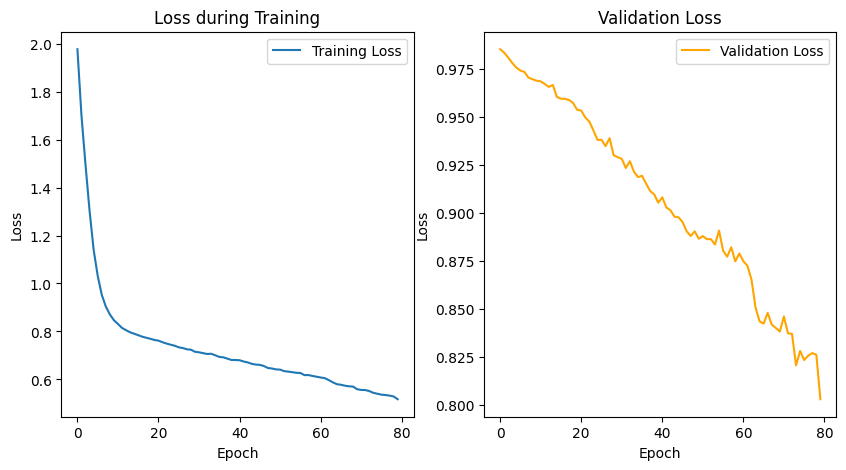

In [26]:
val_losses_cpu = [loss.cpu().numpy() for loss in val_losses]

# ---- GRAPHIQUES ----
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss during Training")
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_losses_cpu, label="Validation Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.legend()

plt.show()

In [28]:
model_pre_training.eval()  # Met le modèle en mode évaluation

all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels, features in val_loader:
        images, labels, features = images.to(device), labels.to(device), features.to(device)

        # Passer les images dans le modèle
        outputs = model_pre_training(images)

        # Obtenir les prédictions en prenant l'argmax sur la dimension des classes
        preds = torch.argmax(outputs, dim=1).cpu().numpy()  # (batch_size, H, W)
        labels = labels.cpu().numpy()  # (batch_size, H, W)

        # Stocker les résultats pour le calcul du Dice
        all_preds.append(preds)
        all_labels.append(labels)

# Convertir en NumPy
all_preds = np.concatenate(all_preds, axis=0)  # (num_images, H, W)
all_labels = np.concatenate(all_labels, axis=0)  # (num_images, H, W)

# Transformer en DataFrame pour tes fonctions
all_preds_df = pd.DataFrame(all_preds.reshape(all_preds.shape[0], -1))  # (num_images, H*W)
all_labels_df = pd.DataFrame(all_labels.reshape(all_labels.shape[0], -1))  # (num_images, H*W)

# Calcul du Dice Score
dice_score = dice_pandas(all_labels_df, all_preds_df)

print(f"Validation Dice Score: {dice_score:.4f}")

Validation Dice Score: 0.0986


C:\Users\yanni\AppData\Local\Temp\ipykernel_14976\1039583736.py:29: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


In [29]:
torch.cuda.empty_cache()

In [ ]:
import torch
from monai.networks.nets import SwinUNETR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Change img_size to match the actual image size (256, 256)
model = SwinUNETR(
    img_size=(256, 256),  # Match the actual input image size
    in_channels=1,  # Images CT-scan en niveaux de gris
    out_channels=NUM_CLASSES+1,  # Nombre de classes
    use_checkpoint=True,  # Gradient checkpointing pour économiser la mémoire
    spatial_dims=2,  # Important pour utiliser la version 2D
).to(device)

model.load_state_dict(torch.load('best_model_pre_training.pth', weights_only=True))



c:\Users\yanni\anaconda3\lib\site-packages\monai\utils\deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


<All keys matched successfully>

In [ ]:
model.eval()  # Met le modèle en mode évaluation

all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels, features in val_loader:
        images, labels, features = images.to(device), labels.to(device), features.to(device)

        # Passer les images dans le modèle
        outputs = model(images)

        # Obtenir les prédictions en prenant l'argmax sur la dimension des classes
        preds = torch.argmax(outputs, dim=1).cpu().numpy()  # (batch_size, H, W)
        labels = labels.cpu().numpy()  # (batch_size, H, W)

        # Stocker les résultats pour le calcul du Dice
        all_preds.append(preds)
        all_labels.append(labels)

# Convertir en NumPy
all_preds = np.concatenate(all_preds, axis=0)  # (num_images, H, W)
all_labels = np.concatenate(all_labels, axis=0)  # (num_images, H, W)

# Transformer en DataFrame pour tes fonctions
all_preds_df = pd.DataFrame(all_preds.reshape(all_preds.shape[0], -1))  # (num_images, H*W)
all_labels_df = pd.DataFrame(all_labels.reshape(all_labels.shape[0], -1))  # (num_images, H*W)

# Calcul du Dice Score
dice_score = dice_pandas(all_labels_df, all_preds_df)

print(f"Validation Dice Score: {dice_score:.4f}")

Validation Dice Score: 0.0903


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from monai.networks.nets import SwinUNETR  # Assurez-vous d'importer le bon module

class SwinUNETRWithFeatures(nn.Module):
    def __init__(self, 
                 img_size=(256, 256), 
                 in_channels=1, 
                 out_channels=NUM_CLASSES+1,
                 pretrained_model=None):
        super(SwinUNETRWithFeatures, self).__init__()
        
        # Backbone SwinUNETR pré-entraîné
        self.swin_unetr = SwinUNETR(
            img_size=img_size,
            in_channels=in_channels,
            out_channels=out_channels,
            use_checkpoint=True,
            spatial_dims=2
        )
        
        if pretrained_model is not None:
            # Charger les poids pré-entraînés dans le backbone
            self.swin_unetr.load_state_dict(pretrained_model, strict=False)
        
        # Branch pour traiter les patch features
        # Ici on suppose que les patch features sont de taille (384, 16, 16)
        # On peut par exemple les transformer pour obtenir une carte de dimension (C, H, W)
        # afin de les fusionner avec le decoder (ou directement dans le head)
        self.features_conv = nn.Sequential(
            nn.Conv2d(768, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        # Module de fusion (par exemple, concaténer les deux cartes et les traiter)
        # On suppose que la sortie du SwinUNETR est de taille (B, out_channels, H, W)
        # et que l'on veut fusionner la branche features après une redimension
        self.fusion_conv = nn.Sequential(
            nn.Conv2d(out_channels + 64, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, image, patch_feature):
        # Passage dans le modèle de base
        seg_out = self.swin_unetr(image)  # sortie de taille (B, out_channels, H, W)
        
        # Traitement des patch features
        # patch_feature: (B, 384, 16, 16)
        features = self.features_conv(patch_feature)  # -> (B, 64, 16, 16)
        
        # Si nécessaire, redimensionner la carte de features pour qu'elle ait la même taille que seg_out
        # On utilise ici une interpolation bilinéaire
        features_upsampled = F.interpolate(features, size=seg_out.shape[2:], mode='bilinear', align_corners=False)
        
        # Fusionner les deux features (concaténation sur la dimension des canaux)
        fused = torch.cat([seg_out, features_upsampled], dim=1)
        out = self.fusion_conv(fused)
        
        return out


In [37]:
# Supposons que model_swin_both est votre modèle pré-entraîné (instance de SwinUNETR)
pretrained_weights = model.state_dict()

# Créez une instance de votre nouveau modèle en passant les poids pré-entraînés
model_fine_tuning = SwinUNETRWithFeatures(
    img_size=(256, 256), 
    in_channels=1, 
    out_channels=NUM_CLASSES+1, 
    pretrained_model=pretrained_weights
).to(device)


In [ ]:
model_fine_tuning.eval()  # Met le modèle en mode évaluation

all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels, features in val_loader:
        images, labels, features = images.to(device), labels.to(device), features.to(device)

        # Passer les images dans le modèle
        outputs = model_fine_tuning(images, features)

        # Obtenir les prédictions en prenant l'argmax sur la dimension des classes
        preds = torch.argmax(outputs, dim=1).cpu().numpy()  # (batch_size, H, W)
        labels = labels.cpu().numpy()  # (batch_size, H, W)

        # Stocker les résultats pour le calcul du Dice
        all_preds.append(preds)
        all_labels.append(labels)

# Convertir en NumPy
all_preds = np.concatenate(all_preds, axis=0)  # (num_images, H, W)
all_labels = np.concatenate(all_labels, axis=0)  # (num_images, H, W)

# Transformer en DataFrame pour tes fonctions
all_preds_df = pd.DataFrame(all_preds.reshape(all_preds.shape[0], -1))  # (num_images, H*W)
all_labels_df = pd.DataFrame(all_labels.reshape(all_labels.shape[0], -1))  # (num_images, H*W)

# Calcul du Dice Score
dice_score = dice_pandas(all_labels_df, all_preds_df)

print(f"Validation Dice Score: {dice_score:.4f}")

Validation Dice Score: 0.0004


In [41]:
# Fine-tune the model

# Définir l'optimiseur avec des taux d'apprentissage différenciés
optimizer = torch.optim.AdamW([
    {"params": model_fine_tuning.swin_unetr.parameters(), "lr": 0.00001},  # Taux faible pour le backbone pré-entraîné
    {"params": list(model_fine_tuning.features_conv.parameters()) + list(model_fine_tuning.fusion_conv.parameters()), "lr": 0.0005}  # Taux plus élevé pour les nouvelles couches
])
 
ce_loss = nn.CrossEntropyLoss()
dice_loss = DiceLoss(NUM_CLASSES+1)
num_epochs = 100
losses = []
val_losses = []
counter = 0  # Compteur d'époques sans amélioration
patience = 10  # Nombre d'époques sans amélioration avant d'arrêter
best_val_loss = float('inf')

for epoch in tqdm(range(num_epochs)):
    model_fine_tuning.train()
    running_loss = 0.0

    for images, labels, features in train_loader_2:
        images, labels, features = images.to(device), labels.to(device), features.to(device)

        optimizer.zero_grad()
        outputs = model_fine_tuning(images, features)

        loss_ce = ce_loss(outputs, labels)
        loss_dice = dice_loss(outputs, labels, softmax=True)
        loss = 0.4 * loss_ce + 0.6 * loss_dice
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    losses.append(running_loss / len(train_loader_2))
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader_2):.4f}")

    # ---- ÉVALUATION ----
    model_fine_tuning.eval()  # Met le modèle en mode évaluation

    val_loss = 0.0  # Variable pour accumuler la perte de validation
    with torch.no_grad():
        for images, labels, features in val_loader:
            images, labels, features = images.to(device), labels.to(device), features.to(device)

            # Passer les images dans le modèle
            outputs = model_fine_tuning(images, features)

            # Calcul de la CrossEntropyLoss
            loss_dice = dice_loss(outputs, labels, softmax=True)
            val_loss +=  loss_dice

    # Moyenne de la perte de validation
    val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {val_loss:.4f}")

    # Optionnel : afficher la progression de la perte de validation
    val_losses.append(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0  # Reset counter if validation loss improves
        torch.save(model_fine_tuning.state_dict(), 'best_model_fine_tuning.pth')  # Save the best model
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Loss: 1.9379


  1%|          | 1/100 [01:43<2:50:31, 103.35s/it]

Validation Loss: 0.8917
Epoch [2/100], Loss: 1.8810


  2%|▏         | 2/100 [02:56<2:19:41, 85.53s/it] 

Validation Loss: 0.8821
Epoch [3/100], Loss: 1.8416


  3%|▎         | 3/100 [04:09<2:09:18, 79.99s/it]

Validation Loss: 0.8743
Epoch [4/100], Loss: 1.8087


  4%|▍         | 4/100 [05:23<2:03:51, 77.41s/it]

Validation Loss: 0.8742
Epoch [5/100], Loss: 1.7788


  5%|▌         | 5/100 [06:37<2:00:31, 76.12s/it]

Validation Loss: 0.8702
Epoch [6/100], Loss: 1.7537


  6%|▌         | 6/100 [07:50<1:57:50, 75.22s/it]

Validation Loss: 0.8691
Epoch [7/100], Loss: 1.7311


  7%|▋         | 7/100 [09:03<1:55:33, 74.55s/it]

Validation Loss: 0.8727
Epoch [8/100], Loss: 1.7116


  8%|▊         | 8/100 [10:16<1:53:39, 74.13s/it]

Validation Loss: 0.8778
Epoch [9/100], Loss: 1.6923


  9%|▉         | 9/100 [11:27<1:50:57, 73.15s/it]

Validation Loss: 0.8726
Epoch [10/100], Loss: 1.6738


 10%|█         | 10/100 [12:29<1:44:19, 69.55s/it]

Validation Loss: 0.8662
Epoch [11/100], Loss: 1.6560


 11%|█         | 11/100 [13:30<1:39:30, 67.08s/it]

Validation Loss: 0.8661
Epoch [12/100], Loss: 1.6372


 12%|█▏        | 12/100 [14:32<1:35:51, 65.36s/it]

Validation Loss: 0.8671
Epoch [13/100], Loss: 1.6205


 13%|█▎        | 13/100 [15:33<1:33:04, 64.19s/it]

Validation Loss: 0.8755
Epoch [14/100], Loss: 1.6065


 14%|█▍        | 14/100 [16:35<1:30:51, 63.39s/it]

Validation Loss: 0.8693
Epoch [15/100], Loss: 1.5939


 15%|█▌        | 15/100 [17:36<1:28:57, 62.79s/it]

Validation Loss: 0.8682
Epoch [16/100], Loss: 1.5796


 16%|█▌        | 16/100 [18:38<1:27:20, 62.39s/it]

Validation Loss: 0.8667
Epoch [17/100], Loss: 1.5646


 17%|█▋        | 17/100 [19:39<1:25:57, 62.14s/it]

Validation Loss: 0.8707
Epoch [18/100], Loss: 1.5485


 18%|█▊        | 18/100 [20:41<1:24:38, 61.93s/it]

Validation Loss: 0.8791
Epoch [19/100], Loss: 1.5355


 19%|█▉        | 19/100 [21:42<1:23:23, 61.77s/it]

Validation Loss: 0.8745
Epoch [20/100], Loss: 1.5243


 20%|██        | 20/100 [22:44<1:22:12, 61.66s/it]

Validation Loss: 0.8760
Epoch [21/100], Loss: 1.5121


 20%|██        | 20/100 [23:45<1:35:02, 71.28s/it]

Validation Loss: 0.8691
Early stopping triggered


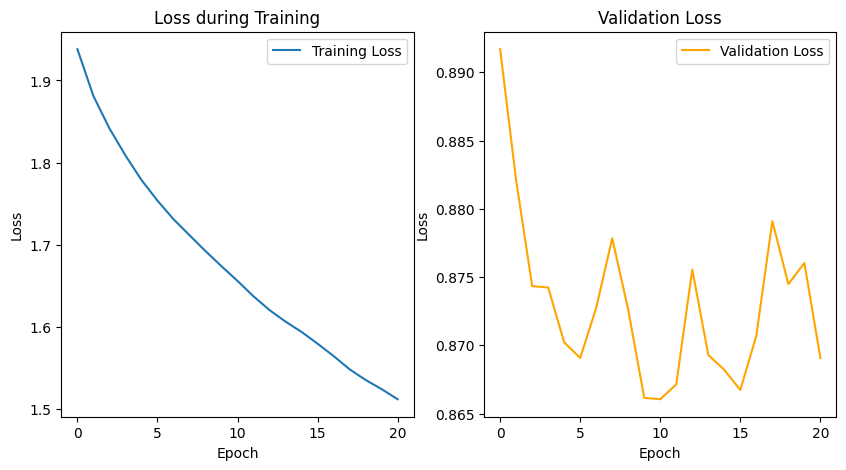

In [42]:
val_losses_cpu = [loss.cpu().numpy() for loss in val_losses]   

# ---- GRAPHIQUES ----
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss during Training")
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_losses_cpu, label="Validation Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.legend()

plt.show()

In [43]:
model_fine_tuning.eval()  # Met le modèle en mode évaluation

all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels, features in val_loader:
        images, labels, features = images.to(device), labels.to(device), features.to(device)

        # Passer les images dans le modèle
        outputs = model_fine_tuning(images, features)

        # Obtenir les prédictions en prenant l'argmax sur la dimension des classes
        preds = torch.argmax(outputs, dim=1).cpu().numpy()  # (batch_size, H, W)
        labels = labels.cpu().numpy()  # (batch_size, H, W)

        # Stocker les résultats pour le calcul du Dice
        all_preds.append(preds)
        all_labels.append(labels)

# Convertir en NumPy
all_preds = np.concatenate(all_preds, axis=0)  # (num_images, H, W)
all_labels = np.concatenate(all_labels, axis=0)  # (num_images, H, W)

# Transformer en DataFrame pour tes fonctions
all_preds_df = pd.DataFrame(all_preds.reshape(all_preds.shape[0], -1))  # (num_images, H*W)
all_labels_df = pd.DataFrame(all_labels.reshape(all_labels.shape[0], -1))  # (num_images, H*W)

# Calcul du Dice Score
dice_score = dice_pandas(all_labels_df, all_preds_df)

print(f"Validation Dice Score: {dice_score:.4f}")

Validation Dice Score: 0.0923


In [44]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm

# Function to get predictions
def get_predictions(model, dataloader, device):
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for images, features in tqdm(dataloader, desc="Generating predictions"):
            images, features = images.to(device), features.to(device)
            outputs = model(images, features)  # Output shape: (batch_size, num_classes, 256, 256)
            preds = torch.argmax(outputs, dim=1)  # Get the most probable class
            predictions.append(preds.cpu().numpy())  # Convert to numpy

    return np.concatenate(predictions, axis=0)  # Final shape: (N, 256, 256)

# Get predictions on the test set
predictions_test = get_predictions(model_fine_tuning, test_loader, device)  # Shape: (N, 256, 256)
print("Predictions shape:", predictions_test.shape)

# Reshape predictions to have one row per pixel (instead of image)
n_images = predictions_test.shape[0]  # Number of images
n_pixels = 256 * 256  # Total number of pixels (256 * 256)

# Correct reshaping: each row represents a pixel, and each column an image
predictions_flat = predictions_test.transpose(1, 2, 0).reshape(n_pixels, n_images)  # Shape: (256*256, N)

# Create DataFrame
columns = [f"{i}.png" for i in range(n_images)]
df = pd.DataFrame(predictions_flat, columns=columns)  # Each column is an image

# Add a 'Pixel' column for each row representing pixel positions
df.insert(0, "Pixel", [f"Pixel {i}" for i in range(n_pixels)])

# Save to CSV with proper formatting
df.to_csv("predictions_with_features.csv", index=False, encoding='utf-8')
print("CSV file saved successfully!")

Generating predictions: 100%|██████████| 63/63 [00:39<00:00,  1.61it/s]


Predictions shape: (500, 256, 256)
CSV file saved successfully!


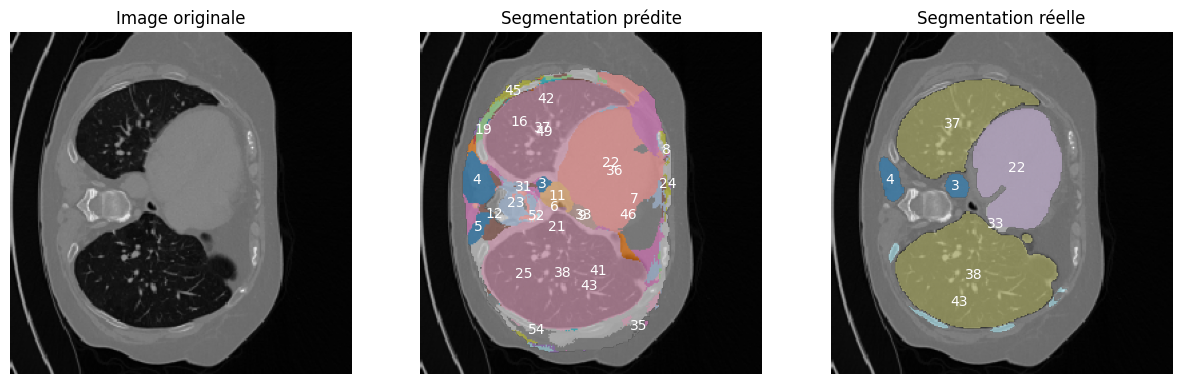

In [54]:
# Fonction pour afficher une image, sa prédiction et son label réel
def plot_slice_seg(image, pred, label, idx=0):
    """
    Affiche une image en niveaux de gris avec la segmentation prédite et la segmentation réelle.

    image : image originale (3D ou 2D)
    pred  : prédiction du modèle (2D, classes)
    label : ground truth (2D, classes)
    idx   : index de l'exemple à afficher
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Affichage de l'image originale
    axes[0].imshow(image[idx % image.shape[0]].squeeze(), cmap="gray") # Use modulo operator to ensure idx is within bounds
    axes[0].set_title("Image originale")

    # Affichage de la prédiction
    pred_masked = np.ma.masked_where(pred[idx % pred.shape[0]] == 0, pred[idx % pred.shape[0]])  # Masquer le fond (classe 0) # Use modulo operator to ensure idx is within bounds
    axes[1].imshow(image[idx % image.shape[0]].squeeze(), cmap="gray") # Use modulo operator to ensure idx is within bounds
    axes[1].imshow(pred_masked, cmap="tab20", alpha=0.6)
    axes[1].set_title("Segmentation prédite")

    # Affichage du label réel
    label_masked = np.ma.masked_where(label[idx % label.shape[0]] == 0, label[idx % label.shape[0]]) # Use modulo operator to ensure idx is within bounds
    axes[2].imshow(image[idx % image.shape[0]].squeeze(), cmap="gray") # Use modulo operator to ensure idx is within bounds
    axes[2].imshow(label_masked, cmap="tab20", alpha=0.6)
    axes[2].set_title("Segmentation réelle")

    # Ajout des numéros de classe
    for i in range(1, NUM_CLASSES + 1): # On ignore le fond (classe 0)
        # Trouver les coordonnées des pixels appartenant à la classe i
        pred_coords = np.argwhere(pred[idx % pred.shape[0]] == i)
        label_coords = np.argwhere(label[idx % label.shape[0]] == i)

        # Afficher le numéro de classe au centre de la zone (approximativement)
        if len(pred_coords) > 0:
            center_pred = pred_coords.mean(axis=0).astype(int)
            axes[1].text(center_pred[1], center_pred[0], str(i), color='white', ha='center', va='center')
        if len(label_coords) > 0:
            center_label = label_coords.mean(axis=0).astype(int)
            axes[2].text(center_label[1], center_label[0], str(i), color='white', ha='center', va='center')


    for ax in axes:
        ax.axis("off")

    plt.show()

# Sélectionner un index aléatoire pour visualiser un exemple de validation
idx = np.random.randint(len(val_dataset)-1)  # Si val_dataset est ta liste d'images de validation

# Get a batch of images, labels, and features from the validation loader at the random index
image, label, feature = val_dataset[idx]
image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
feature = feature.unsqueeze(0).to(device)  # Add batch dimension and move to device

with torch.no_grad():
    output = model_fine_tuning(image, feature)  # Get the model's prediction
    pred = torch.argmax(output, dim=1).cpu().numpy()  # Get the predicted class labels

plot_slice_seg(
    image.cpu().numpy(),  # Images d'entrée (tensor → NumPy)
    pred,  # Prédictions (déjà en NumPy)
    label.unsqueeze(0).numpy(),  # Labels réels (déjà en NumPy) # Add batch dimension
    idx  # Index to use for plotting (always 0 since we're using a single image)
)